Envrionment Setup for MountainCarContinuous-v0

In [1]:
import tensorflow as tf

print("TF version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPUs visible to TF:", tf.config.list_physical_devices("CPU"))

# Optional: show detailed GPU info
for g in tf.config.list_physical_devices("CPU"):
    print(" -", g)

# If this prints [] => you're on CPU only


/Users/tonywu/venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TF version: 2.20.0
Built with CUDA: False
GPUs visible to TF: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
 - PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [2]:
import sys, platform
print(sys.executable)
print(platform.platform())


/Users/tonywu/venv/bin/python
macOS-15.6.1-arm64-arm-64bit


In [3]:
# ============================
# Cell 1 — Imports + Config
# ============================
import os
import time
import math
import numpy as np

import gymnasium as gym

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display

from PIL import Image

np.set_printoptions(precision=4, suppress=True)

SEED = 0
rng = np.random.default_rng(SEED)


In [4]:
# ============================
# Cell 2 — Env Factory + Basics
# ============================

ENV_ID = "MountainCarContinuous-v0"

def make_env(render_mode=None, seed=0):
    """
    render_mode:
      - None: fastest (training)
      - "rgb_array": frames for notebook animation
      - "human": pops up window (not great for notebook)
    """
    env = gym.make(ENV_ID, render_mode=render_mode)
    obs, info = env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env

# Quick sanity check
env = make_env(render_mode=None, seed=SEED)
obs, info = env.reset()
print("obs:", obs, "shape:", obs.shape)
print("action_space:", env.action_space)
print("observation_space:", env.observation_space)

# Useful constants
OBS_DIM = env.observation_space.shape[0]   # 2: [position, velocity]
ACT_DIM = env.action_space.shape[0]        # 1: [force]
ACTION_LOW  = env.action_space.low.copy()
ACTION_HIGH = env.action_space.high.copy()

# Gym's goal is typically around position ~ 0.45 (varies by implementation)
GOAL_POS_DEFAULT = 0.45
env.close()


obs: [-0.546  0.   ] shape: (2,)
action_space: Box(-1.0, 1.0, (1,), float32)
observation_space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


In [5]:
# ============================
# Cell 3 — Notebook Render Utilities
# ============================

def resize_frame(frame, size=(640, 400)):
    """frame: HxWx3 uint8"""
    if size is None:
        return frame
    img = Image.fromarray(frame)
    img = img.resize(size, resample=Image.BILINEAR)
    return np.asarray(img)

def rollout_and_render(env, policy_fn, steps=600, seed=0,
                       frame_stride=1, resize=(640, 400), fps=30):
    """
    env must be created with render_mode="rgb_array"
    policy_fn(obs) -> action in [-1,1] shape (1,)
    """
    obs, info = env.reset(seed=seed)
    frames = []
    traj = []

    for t in range(steps):
        action = np.asarray(policy_fn(obs), dtype=np.float32).reshape(ACT_DIM,)
        action = np.clip(action, ACTION_LOW, ACTION_HIGH)

        obs2, reward, terminated, truncated, info = env.step(action)
        traj.append((obs.copy(), action.copy(), reward, terminated, truncated))

        if t % frame_stride == 0:
            frame = env.render()
            frame = resize_frame(frame, size=resize)
            frames.append(frame)

        obs = obs2
        if terminated or truncated:
            break

    # ---- animate ----
    fig = plt.figure(figsize=(resize[0]/100, resize[1]/100), dpi=100)
    plt.axis("off")
    im = plt.imshow(frames[0])

    def animate(i):
        im.set_data(frames[i])
        return [im]

    ani = animation.FuncAnimation(
        fig, animate, frames=len(frames),
        interval=1000 / fps, blit=True
    )
    plt.close(fig)
    display(HTML(ani.to_jshtml()))
    return traj

def random_policy(obs):
    # MountainCarContinuous expects 1D action in [-1,1]
    return rng.uniform(low=-1.0, high=1.0, size=(1,))


Initial Random data collection


/Users/tonywu/venv/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


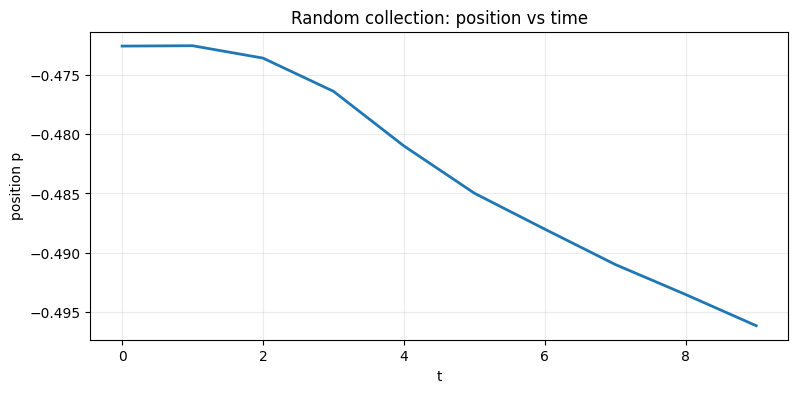

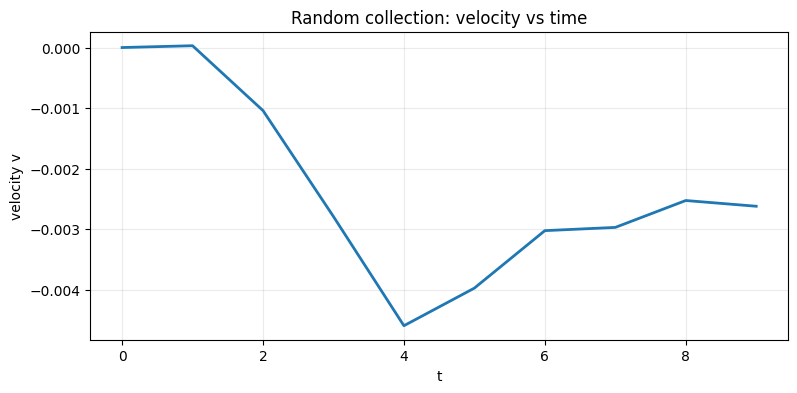

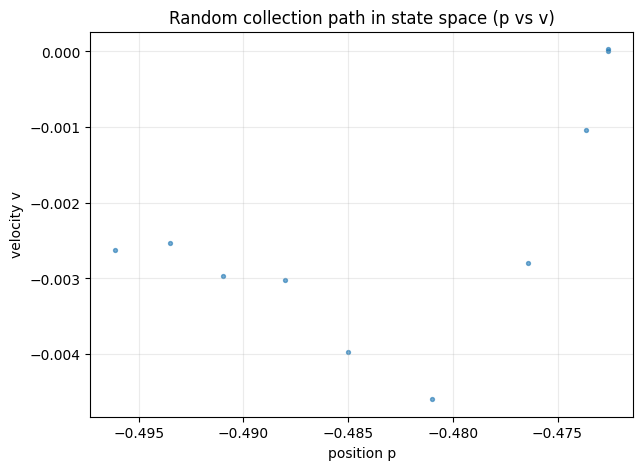

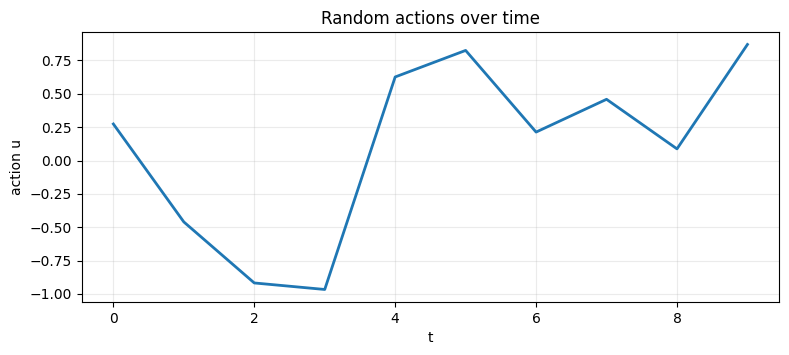

Collected X shape: (10, 3)  (p,v,u)
Collected Y shape: (10, 2)  (dp,dv)


In [6]:
# ============================
# Render the RANDOM collection path (and collect X,Y)
# ============================

import numpy as np
import matplotlib.pyplot as plt

def collect_random_transitions_rendered(n_steps=500, seed=0,
                                       frame_stride=1, resize=(720, 450), fps=30):
    """
    Runs random actions, collects (X,Y), AND renders the rollout.
    X = [p,v,u], Y = [dp,dv]
    """
    rng = np.random.default_rng(seed)

    env_vis = make_env(render_mode="rgb_array", seed=seed)
    obs, info = env_vis.reset(seed=seed)

    X_list, Y_list = [], []
    traj_p, traj_v, traj_u = [], [], []
    frames = []

    for t in range(n_steps):
        u = rng.uniform(-1.0, 1.0, size=(1,)).astype(np.float64)
        obs2, reward, terminated, truncated, info = env_vis.step(u)

        p, v = obs
        p2, v2 = obs2
        dp = p2 - p
        dv = v2 - v

        X_list.append([p, v, float(u[0])])
        Y_list.append([dp, dv])

        traj_p.append(p)
        traj_v.append(v)
        traj_u.append(float(u[0]))

        # render frame
        if (t % frame_stride) == 0:
            frame = env_vis.render()
            frame = resize_frame(frame, size=resize)
            frames.append(frame)

        obs = obs2
        if terminated or truncated:
            obs, info = env_vis.reset(seed=seed + 123 + t)

    env_vis.close()

    X = np.asarray(X_list, dtype=np.float64)
    Y = np.asarray(Y_list, dtype=np.float64)

    # ---- show animation ----
    fig = plt.figure(figsize=(resize[0]/100, resize[1]/100), dpi=100)
    plt.axis("off")
    im = plt.imshow(frames[0])

    from matplotlib import animation
    from IPython.display import HTML, display

    def animate(i):
        im.set_data(frames[i])
        return [im]

    ani = animation.FuncAnimation(
        fig, animate, frames=len(frames),
        interval=1000 / fps, blit=True
    )
    plt.close(fig)
    display(HTML(ani.to_jshtml()))

    # ---- show trajectory plots ----
    traj_p = np.array(traj_p)
    traj_v = np.array(traj_v)
    traj_u = np.array(traj_u)

    plt.figure(figsize=(9, 4))
    plt.plot(traj_p, linewidth=2)
    plt.xlabel("t")
    plt.ylabel("position p")
    plt.title("Random collection: position vs time")
    plt.grid(True, alpha=0.25)
    plt.show()

    plt.figure(figsize=(9, 4))
    plt.plot(traj_v, linewidth=2)
    plt.xlabel("t")
    plt.ylabel("velocity v")
    plt.title("Random collection: velocity vs time")
    plt.grid(True, alpha=0.25)
    plt.show()

    plt.figure(figsize=(7, 5))
    plt.scatter(traj_p, traj_v, s=8, alpha=0.6)
    plt.xlabel("position p")
    plt.ylabel("velocity v")
    plt.title("Random collection path in state space (p vs v)")
    plt.grid(True, alpha=0.25)
    plt.show()

    plt.figure(figsize=(9, 3.5))
    plt.plot(traj_u, linewidth=2)
    plt.xlabel("t")
    plt.ylabel("action u")
    plt.title("Random actions over time")
    plt.grid(True, alpha=0.25)
    plt.show()

    print("Collected X shape:", X.shape, " (p,v,u)")
    print("Collected Y shape:", Y.shape, " (dp,dv)")
    return X, Y


# ---- run it ----
X0, Y0 = collect_random_transitions_rendered(
    n_steps=10,
    seed=SEED,
    frame_stride=4,
    resize=(720, 450),
    fps=12
)


In [7]:
# ============================
# Cell 7 — GPflow Setup (float64)
# ============================
import tensorflow as tf
import gpflow
from gpflow.inducing_variables import InducingPoints

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-6)
tf.keras.backend.set_floatx("float64")

print("TF:", tf.__version__)
print("GPflow:", gpflow.__version__)


TF: 2.20.0
GPflow: 2.10.0


OSGPR-VFE


In [8]:
# ===========================
# Cell 8 — Streaming OSGPR (VFE) — paper-style regression update (D-dim input)
#   Works for MountainCar input x=[p,v,u] (D=3)
#   Single-output GP (we train two models: dp and dv)
#   ✅ Includes caching for VERY fast predict (needed for MPPI)
# ===========================

import time
import numpy as np
import tensorflow as tf
import gpflow

from gpflow.inducing_variables import InducingPoints
from gpflow.models import GPModel, InternalDataTrainingLossMixin
from gpflow import covariances

# --- stable numerics ---
gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-6)
tf.keras.backend.set_floatx("float64")


# ---------------------------
# helpers
# ---------------------------
def sym_jitter(A, jitter=1e-6):
    A = np.asarray(A, dtype=np.float64)
    A = 0.5 * (A + A.T)
    A = A + jitter * np.eye(A.shape[0], dtype=np.float64)
    return A

def finite_mask(*arrs):
    m = None
    for a in arrs:
        a = np.asarray(a)
        mm = np.isfinite(a).all(axis=1) if a.ndim == 2 else np.isfinite(a)
        m = mm if m is None else (m & mm)
    return m

def choose_inducing_keep_old(Z_old, X_new, M, keep_frac=0.8, rng=None):
    """
    D-dimensional inducing management:
      keep_frac of old inducing points + rest from current batch.
    Z_old: (M_old, D)
    X_new: (N_new, D)
    """
    if rng is None:
        rng = np.random.default_rng(0)

    Z_old = np.asarray(Z_old, dtype=np.float64)
    X_new = np.asarray(X_new, dtype=np.float64)

    assert Z_old.ndim == 2 and X_new.ndim == 2
    D = Z_old.shape[1]
    assert X_new.shape[1] == D, f"Dim mismatch: Z_old D={D}, X_new D={X_new.shape[1]}"

    M_keep = int(np.round(M * keep_frac))
    M_new  = M - M_keep
    M_keep = min(M_keep, Z_old.shape[0])
    M_new  = min(M_new,  X_new.shape[0])

    old_idx = rng.choice(Z_old.shape[0], size=M_keep, replace=False) if M_keep > 0 else np.array([], dtype=int)
    new_idx = rng.choice(X_new.shape[0], size=M_new,  replace=False) if M_new  > 0 else np.array([], dtype=int)

    Z = np.vstack([Z_old[old_idx], X_new[new_idx]]).astype(np.float64)

    if Z.shape[0] < M:
        need = M - Z.shape[0]
        extra = rng.choice(X_new.shape[0], size=need, replace=True)
        Z = np.vstack([Z, X_new[extra]])
    return Z


# ============================================================
# OSGPR-VFE model (Bui et al., NIPS 2017) — VFE case
# ============================================================
class OSGPR_VFE(GPModel, InternalDataTrainingLossMixin):
    """
    Online Sparse Variational GP Regression (VFE), regression-only.
    SINGLE-OUTPUT. Train two models for dp and dv.

    ✅ Includes prediction cache for fast MPPI:
      - build_predict_cache()
      - predict_f_cached()
    """

    def __init__(self, data, kernel, mu_old, Su_old, Kaa_old, Z_old, Z, mean_function=None):
        X, Y = gpflow.models.util.data_input_to_tensor(data)
        self.X, self.Y = X, Y
        likelihood = gpflow.likelihoods.Gaussian()
        num_latent_gps = GPModel.calc_num_latent_gps_from_data(data, kernel, likelihood)
        super().__init__(kernel, likelihood, mean_function, num_latent_gps)

        Z = np.asarray(Z, dtype=np.float64)
        assert Z.ndim == 2, "Z must be (M, D)"
        self.inducing_variable = InducingPoints(Z)
        self.num_data = tf.shape(self.X)[0]

        # old summary (fixed)
        mu_old  = np.asarray(mu_old, dtype=np.float64).reshape(-1, 1)
        Su_old  = sym_jitter(Su_old, 1e-6)
        Kaa_old = sym_jitter(Kaa_old, 1e-6)
        Z_old   = np.asarray(Z_old, dtype=np.float64)
        assert Z_old.ndim == 2, "Z_old must be (M_old, D)"

        self.mu_old  = tf.Variable(mu_old,  trainable=False, dtype=gpflow.default_float())
        self.Su_old  = tf.Variable(Su_old,  trainable=False, dtype=gpflow.default_float())
        self.Kaa_old = tf.Variable(Kaa_old, trainable=False, dtype=gpflow.default_float())
        self.Z_old   = tf.Variable(Z_old,   trainable=False, dtype=gpflow.default_float())

        if self.mean_function is None:
            self.mean_function = gpflow.mean_functions.Zero()

        # cache state
        self._cache_ready = False
        self._cache_Lb = None
        self._cache_LD = None
        self._cache_rhs = None

    def _common_terms(self):
        Mb = self.inducing_variable.num_inducing
        jitter = gpflow.utilities.to_default_float(1e-6)
        sigma2 = self.likelihood.variance

        Saa = self.Su_old
        ma  = self.mu_old

        # Kbf, Kbb, Kba, Kaa (old)
        Kbf = covariances.Kuf(self.inducing_variable, self.kernel, self.X)                # [Mb, N]
        Kbb = covariances.Kuu(self.inducing_variable, self.kernel, jitter=jitter)         # [Mb, Mb]
        Kba = covariances.Kuf(self.inducing_variable, self.kernel, self.Z_old)            # [Mb, Ma]

        # current kernel at Z_old (optional mismatch correction term)
        Kaa_cur = gpflow.utilities.add_noise_cov(self.kernel(self.Z_old), jitter)         # current kernel(Z_old,Z_old)
        Kaa = gpflow.utilities.add_noise_cov(self.Kaa_old, jitter)                        # stored old kernel(Z_old,Z_old)

        err = self.Y - self.mean_function(self.X)

        # c = Kbf * (Y/sigma2) + Kba * (Saa^{-1} ma)
        Sainv_ma = tf.linalg.solve(Saa, ma)
        c1 = tf.matmul(Kbf, self.Y / sigma2)                                              # [Mb,1]
        c2 = tf.matmul(Kba, Sainv_ma)                                                     # [Mb,1]
        c  = c1 + c2                                                                      # [Mb,1]

        # Cholesky(Kbb)
        Lb = tf.linalg.cholesky(Kbb)
        Lbinv_c   = tf.linalg.triangular_solve(Lb, c, lower=True)
        Lbinv_Kba = tf.linalg.triangular_solve(Lb, Kba, lower=True)
        Lbinv_Kbf = tf.linalg.triangular_solve(Lb, Kbf, lower=True) / tf.sqrt(sigma2)

        d1 = tf.matmul(Lbinv_Kbf, Lbinv_Kbf, transpose_b=True)                            # [Mb,Mb]

        # d2 = (LSa^{-1} Kab Lb^{-1})^T (LSa^{-1} Kab Lb^{-1})
        LSa = tf.linalg.cholesky(Saa)
        Kab_Lbinv = tf.linalg.matrix_transpose(Lbinv_Kba)                                 # [Ma,Mb]
        LSainv_Kab_Lbinv = tf.linalg.triangular_solve(LSa, Kab_Lbinv, lower=True)
        d2 = tf.matmul(LSainv_Kab_Lbinv, LSainv_Kab_Lbinv, transpose_a=True)

        # d3 = (La^{-1} Kab Lb^{-1})^T (La^{-1} Kab Lb^{-1})
        La = tf.linalg.cholesky(Kaa)
        Lainv_Kab_Lbinv = tf.linalg.triangular_solve(La, Kab_Lbinv, lower=True)
        d3 = tf.matmul(Lainv_Kab_Lbinv, Lainv_Kab_Lbinv, transpose_a=True)

        # D = I + d1 + d2 - d3
        D = tf.eye(Mb, dtype=gpflow.default_float()) + d1 + d2 - d3
        D = gpflow.utilities.add_noise_cov(D, jitter)
        LD = tf.linalg.cholesky(D)

        LDinv_Lbinv_c = tf.linalg.triangular_solve(LD, Lbinv_c, lower=True)

        # Qff_diag term for trace: diag(Kfb Kbb^{-1} Kbf) / sigma2
        Qff_diag = tf.reduce_sum(tf.square(Lbinv_Kbf), axis=0)                             # [N]

        return (Kbf, Kba, Kaa, Kaa_cur, La, Kbb, Lb, D, LD,
                Lbinv_Kba, LDinv_Lbinv_c, err, Qff_diag)

    def maximum_log_likelihood_objective(self):
        jitter = gpflow.utilities.to_default_float(1e-6)
        sigma2 = self.likelihood.variance
        N = tf.cast(self.num_data, gpflow.default_float())

        Saa = self.Su_old
        ma  = self.mu_old

        Kfdiag = self.kernel(self.X, full_cov=False)

        (Kbf, Kba, Kaa, Kaa_cur, La, Kbb, Lb, D, LD,
         Lbinv_Kba, LDinv_Lbinv_c, err, Qff_diag) = self._common_terms()

        # ma term
        LSa = tf.linalg.cholesky(Saa)
        Lainv_ma = tf.linalg.triangular_solve(LSa, ma, lower=True)

        bound = -0.5 * N * np.log(2.0 * np.pi)
        bound += -0.5 * tf.reduce_sum(tf.square(err)) / sigma2
        bound += -0.5 * tf.reduce_sum(tf.square(Lainv_ma))
        bound +=  0.5 * tf.reduce_sum(tf.square(LDinv_Lbinv_c))

        bound += -0.5 * N * tf.math.log(sigma2)
        bound += -tf.reduce_sum(tf.math.log(tf.linalg.diag_part(LD)))

        bound += -0.5 * tf.reduce_sum(Kfdiag) / sigma2
        bound +=  0.5 * tf.reduce_sum(Qff_diag)

        bound += tf.reduce_sum(tf.math.log(tf.linalg.diag_part(La)))
        bound += -tf.reduce_sum(tf.math.log(tf.linalg.diag_part(LSa)))

        Kaadiff = Kaa_cur - tf.matmul(Lbinv_Kba, Lbinv_Kba, transpose_a=True)
        Sainv_Kaadiff = tf.linalg.solve(Saa, Kaadiff)
        Kainv_Kaadiff = tf.linalg.solve(Kaa, Kaadiff)

        bound += -0.5 * tf.reduce_sum(
            tf.linalg.diag_part(Sainv_Kaadiff) - tf.linalg.diag_part(Kainv_Kaadiff)
        )
        return bound

    def predict_f(self, Xnew, full_cov=False):
        # slow but correct; cached version below is used in MPPI
        jitter = gpflow.utilities.to_default_float(1e-6)

        Kbs = covariances.Kuf(self.inducing_variable, self.kernel, Xnew)
        (Kbf, Kba, Kaa, Kaa_cur, La, Kbb, Lb, D, LD,
         Lbinv_Kba, LDinv_Lbinv_c, err, Qff_diag) = self._common_terms()

        Lbinv_Kbs = tf.linalg.triangular_solve(Lb, Kbs, lower=True)
        LDinv_Lbinv_Kbs = tf.linalg.triangular_solve(LD, Lbinv_Kbs, lower=True)
        mean = tf.matmul(LDinv_Lbinv_Kbs, LDinv_Lbinv_c, transpose_a=True)

        if full_cov:
            Kss = self.kernel(Xnew) + jitter * tf.eye(tf.shape(Xnew)[0], dtype=gpflow.default_float())
            var = (
                Kss
                - tf.matmul(Lbinv_Kbs, Lbinv_Kbs, transpose_a=True)
                + tf.matmul(LDinv_Lbinv_Kbs, LDinv_Lbinv_Kbs, transpose_a=True)
            )
            return mean + self.mean_function(Xnew), var
        else:
            var = (
                self.kernel(Xnew, full_cov=False)
                - tf.reduce_sum(tf.square(Lbinv_Kbs), axis=0)
                + tf.reduce_sum(tf.square(LDinv_Lbinv_Kbs), axis=0)
            )
            var = tf.maximum(var, tf.cast(1e-12, var.dtype))
            return mean + self.mean_function(Xnew), var

    # ============================================================
    # ✅ Prediction cache (HUGE speed-up for MPPI)
    # ============================================================
    def build_predict_cache(self):
        """
        Build cached Cholesky factors + vector needed for fast prediction.
        Call AFTER training, and AFTER every streaming update.
        """
        (Kbf, Kba, Kaa, Kaa_cur, La, Kbb, Lb, D, LD,
         Lbinv_Kba, LDinv_Lbinv_c, err, Qff_diag) = self._common_terms()

        self._cache_Lb = Lb
        self._cache_LD = LD
        self._cache_rhs = LDinv_Lbinv_c
        self._cache_ready = True

    def predict_f_cached(self, Xnew, full_cov=False):
        """
        Fast prediction using cached matrices.
        If cache not ready -> fallback to normal predict_f.
        """
        if (not hasattr(self, "_cache_ready")) or (self._cache_ready is not True):
            return self.predict_f(Xnew, full_cov=full_cov)

        jitter = gpflow.utilities.to_default_float(1e-6)

        Lb  = self._cache_Lb
        LD  = self._cache_LD
        rhs = self._cache_rhs

        Kbs = covariances.Kuf(self.inducing_variable, self.kernel, Xnew)  # [M, Nnew]

        Lbinv_Kbs = tf.linalg.triangular_solve(Lb, Kbs, lower=True)
        LDinv_Lbinv_Kbs = tf.linalg.triangular_solve(LD, Lbinv_Kbs, lower=True)
        mean = tf.matmul(LDinv_Lbinv_Kbs, rhs, transpose_a=True)

        if full_cov:
            Kss = self.kernel(Xnew) + jitter * tf.eye(tf.shape(Xnew)[0], dtype=gpflow.default_float())
            var = (
                Kss
                - tf.matmul(Lbinv_Kbs, Lbinv_Kbs, transpose_a=True)
                + tf.matmul(LDinv_Lbinv_Kbs, LDinv_Lbinv_Kbs, transpose_a=True)
            )
            return mean + self.mean_function(Xnew), var
        else:
            var = (
                self.kernel(Xnew, full_cov=False)
                - tf.reduce_sum(tf.square(Lbinv_Kbs), axis=0)
                + tf.reduce_sum(tf.square(LDinv_Lbinv_Kbs), axis=0)
            )
            var = tf.maximum(var, tf.cast(1e-12, var.dtype))
            return mean + self.mean_function(Xnew), var


def train_osgpr(model, iters=250, lr=0.01):
    opt = tf.keras.optimizers.Adam(lr)

    @tf.function
    def step():
        with tf.GradientTape() as tape:
            loss = -model.maximum_log_likelihood_objective()
        grads = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients([(g, v) for g, v in zip(grads, model.trainable_variables) if g is not None])
        return loss

    t0 = time.time()
    last = None
    for _ in range(iters):
        last = step()
    dt = time.time() - t0
    return dt, float(last.numpy())


def prior_summary(kernel, Z):
    Z = np.asarray(Z, dtype=np.float64)
    Kzz = kernel.K(Z).numpy()
    Kzz = sym_jitter(Kzz, 1e-6)
    mu0 = np.zeros((Z.shape[0], 1), dtype=np.float64)
    return mu0, Kzz, Kzz, Z


def extract_summary_from_model(model):
    Z = model.inducing_variable.Z.numpy()

    mu_tf, Sigma_tf = model.predict_f(Z, full_cov=True)  # u = f(Z)
    mu = mu_tf.numpy()

    Sigma = Sigma_tf.numpy()
    if Sigma.ndim == 3:
        Sigma = Sigma[0]
    Sigma = sym_jitter(Sigma, 1e-6)

    Kaa = model.kernel.K(Z).numpy()
    Kaa = sym_jitter(Kaa, 1e-6)

    return mu, Sigma, Kaa, Z


In [9]:
# ===========================
# Cell 9 — Train initial streaming OSGPR-VFE GPs for dp and dv
#   Requires:
#     X0: (N,3)  [p,v,u]
#     Y0: (N,2)  [dp,dv]
# ===========================

rng = np.random.default_rng(SEED)

# targets
y_dp = Y0[:, 0:1].astype(np.float64)
y_dv = Y0[:, 1:2].astype(np.float64)

# inducing size
M = 64
idxZ = rng.choice(X0.shape[0], size=min(M, X0.shape[0]), replace=False)
Z0 = X0[idxZ].copy()

# kernels (3D input: p,v,u)
kernel_dp = gpflow.kernels.SquaredExponential(lengthscales=[0.5, 0.2, 0.5], variance=1.0)
kernel_dv = gpflow.kernels.SquaredExponential(lengthscales=[0.5, 0.2, 0.5], variance=1.0)

# ===== dp model =====
mu_old, Su_old, Kaa_old, Z_old = prior_summary(kernel_dp, Z0)
m_dp = OSGPR_VFE(
    data=(X0, y_dp),
    kernel=kernel_dp,
    mu_old=mu_old, Su_old=Su_old, Kaa_old=Kaa_old, Z_old=Z_old,
    Z=Z0
)
m_dp.likelihood.variance.assign(1e-4)

print("Training dp model...")
t_dp, neg_dp = train_osgpr(m_dp, iters=300, lr=0.02)
print(f"dp done | train={t_dp:.3f}s | neg_obj={neg_dp:.4f}")

# ===== dv model =====
mu_old, Su_old, Kaa_old, Z_old = prior_summary(kernel_dv, Z0)
m_dv = OSGPR_VFE(
    data=(X0, y_dv),
    kernel=kernel_dv,
    mu_old=mu_old, Su_old=Su_old, Kaa_old=Kaa_old, Z_old=Z_old,
    Z=Z0
)
m_dv.likelihood.variance.assign(1e-4)

print("\nTraining dv model...")
t_dv, neg_dv = train_osgpr(m_dv, iters=300, lr=0.02)
print(f"dv done | train={t_dv:.3f}s | neg_obj={neg_dv:.4f}")

# ✅ build caches (critical for MPPI speed)
m_dp.build_predict_cache()
m_dv.build_predict_cache()
print("\n✅ Prediction caches ready for MPPI")


Training dp model...
dp done | train=1.719s | neg_obj=-31.4531

Training dv model...
dv done | train=0.931s | neg_obj=-31.8322

✅ Prediction caches ready for MPPI


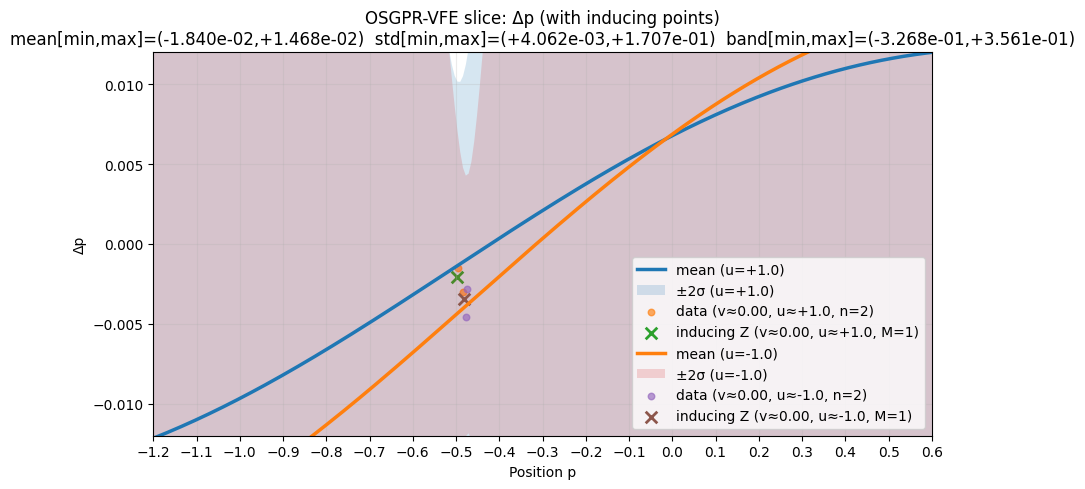

In [10]:
# ============================
# Cell 10 — GP Visualization (+ Inducing points overlay)
#   - Slice (Matplotlib)
#   - 3D Surface INTERACTIVE (Plotly) ✅ spin/zoom
# ============================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import plotly.graph_objects as go

MC_P_MIN, MC_P_MAX = -1.2, 0.6
MC_V_MIN, MC_V_MAX = -0.07, 0.07


def gp_predict_mu_std_fast(model, X):
    """
    Uses cached predict if available
    X: (N,3) -> mu (N,), std (N,)
    """
    X = np.asarray(X, dtype=np.float64)
    if hasattr(model, "predict_f_cached"):
        mu_tf, var_tf = model.predict_f_cached(X, full_cov=False)
    else:
        mu_tf, var_tf = model.predict_f(X, full_cov=False)

    mu = mu_tf.numpy().reshape(-1)
    var = var_tf.numpy().reshape(-1)
    std = np.sqrt(np.maximum(var, 1e-12))
    return mu, std


def get_inducing_Z_np(model):
    """Safely fetch inducing locations Z as numpy array (M,3)."""
    if hasattr(model, "inducing_variable") and hasattr(model.inducing_variable, "Z"):
        return model.inducing_variable.Z.numpy()
    return None


# ============================================================
# 1) Slice plot with axis control + Inducing points overlay
# ============================================================
def plot_slice_two_actions(
    model,
    X_train, y_train,
    title="Slice",
    y_label="Δy",
    v_fixed=0.0,
    a_list=(+1.0, -1.0),
    n_grid=280,
    x_min=MC_P_MIN, x_max=MC_P_MAX,
    y_min=None, y_max=None,
    x_tick_step=None,
    y_tick_step=None,
    data_tol_v=0.01,
    data_tol_a=0.2,
    show_data=True,
    show_minmax=True,
    # --- inducing points ---
    show_inducing=True,
    inducing_tol_v=0.01,
    inducing_tol_a=0.2,
):
    p_grid = np.linspace(x_min, x_max, n_grid)

    curves = []
    auto_ymin = +np.inf
    auto_ymax = -np.inf

    Z = get_inducing_Z_np(model)

    for a_fixed in a_list:
        X_query = np.column_stack([
            p_grid,
            np.full_like(p_grid, v_fixed),
            np.full_like(p_grid, a_fixed),
        ]).astype(np.float64)

        mu, std = gp_predict_mu_std_fast(model, X_query)
        lo = mu - 2 * std
        hi = mu + 2 * std

        curves.append((a_fixed, mu, std, lo, hi))
        auto_ymin = min(auto_ymin, float(np.min(lo)))
        auto_ymax = max(auto_ymax, float(np.max(hi)))

    if y_min is None:
        y_min = auto_ymin
    if y_max is None:
        y_max = auto_ymax

    plt.figure(figsize=(9, 5))

    for a_fixed, mu, std, lo, hi in curves:
        plt.plot(p_grid, mu, lw=2.5, label=f"mean (u={a_fixed:+.1f})")
        plt.fill_between(p_grid, lo, hi, alpha=0.18, label=f"±2σ (u={a_fixed:+.1f})")

        # ----- training data -----
        if show_data:
            X_train = np.asarray(X_train)
            y_train = np.asarray(y_train).reshape(-1)
            mask = (np.abs(X_train[:, 1] - v_fixed) < data_tol_v) & (np.abs(X_train[:, 2] - a_fixed) < data_tol_a)
            if np.sum(mask) > 0:
                plt.scatter(
                    X_train[mask, 0], y_train[mask],
                    s=22, alpha=0.65,
                    label=f"data (v≈{v_fixed:.2f}, u≈{a_fixed:+.1f}, n={np.sum(mask)})"
                )

        # ----- inducing points -----
        if show_inducing and (Z is not None):
            maskZ = (np.abs(Z[:, 1] - v_fixed) < inducing_tol_v) & (np.abs(Z[:, 2] - a_fixed) < inducing_tol_a)
            if np.sum(maskZ) > 0:
                Zsel = Z[maskZ]
                muZ, _ = gp_predict_mu_std_fast(model, Zsel)
                plt.scatter(
                    Zsel[:, 0], muZ,
                    marker="x", s=70, linewidths=2.0,
                    label=f"inducing Z (v≈{v_fixed:.2f}, u≈{a_fixed:+.1f}, M={np.sum(maskZ)})"
                )

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel("Position p")
    plt.ylabel(y_label)

    ax = plt.gca()
    if x_tick_step is not None:
        ax.xaxis.set_major_locator(MultipleLocator(float(x_tick_step)))
    if y_tick_step is not None:
        ax.yaxis.set_major_locator(MultipleLocator(float(y_tick_step)))

    plt.grid(True, alpha=0.25)

    if show_minmax:
        mu_all = np.concatenate([c[1] for c in curves])
        std_all = np.concatenate([c[2] for c in curves])
        lo_all = np.concatenate([c[3] for c in curves])
        hi_all = np.concatenate([c[4] for c in curves])

        extra = (f"\nmean[min,max]=({mu_all.min():+.3e},{mu_all.max():+.3e})"
                 f"  std[min,max]=({std_all.min():+.3e},{std_all.max():+.3e})"
                 f"  band[min,max]=({lo_all.min():+.3e},{hi_all.max():+.3e})")
        plt.title(title + extra)
    else:
        plt.title(title)

    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


# ============================================================
# 2) Plotly interactive 3D surface:
#     z = mean, color = std + Inducing points overlay
# ============================================================
def plot_surface_mean_colored_by_std_interactive(
    model,
    X_train, y_train,
    title="3D Surface (interactive)",
    z_label="Δy",
    a_fixed=+1.0,
    n_grid=80,
    p_min=MC_P_MIN, p_max=MC_P_MAX,
    v_min=MC_V_MIN, v_max=MC_V_MAX,
    z_min=None, z_max=None,
    std_min=None, std_max=None,
    show_data=True,
    data_tol_a=0.2,
    # --- inducing points ---
    show_inducing=True,
    inducing_tol_a=0.2,
):
    p_grid = np.linspace(p_min, p_max, n_grid)
    v_grid = np.linspace(v_min, v_max, n_grid)
    P, V = np.meshgrid(p_grid, v_grid)

    X_grid = np.column_stack([
        P.ravel(),
        V.ravel(),
        np.full_like(P.ravel(), a_fixed)
    ]).astype(np.float64)

    mu, std = gp_predict_mu_std_fast(model, X_grid)
    Mean = mu.reshape(P.shape)
    Std  = std.reshape(P.shape)

    if z_min is None:
        z_min = float(np.min(Mean))
    if z_max is None:
        z_max = float(np.max(Mean))
    if std_min is None:
        std_min = float(np.min(Std))
    if std_max is None:
        std_max = float(np.max(Std))

    surface = go.Surface(
        x=P, y=V, z=Mean,
        surfacecolor=Std,
        colorscale="Viridis",
        cmin=std_min, cmax=std_max,
        colorbar=dict(title="Std (uncertainty)"),
        opacity=0.95,
        showscale=True,
        name="surface"
    )

    traces = [surface]

    # --- overlay training points near action ---
    if show_data:
        X_train = np.asarray(X_train)
        y_train = np.asarray(y_train).reshape(-1)
        act = X_train[:, 2]
        mask = np.abs(act - a_fixed) < data_tol_a
        if np.sum(mask) > 0:
            traces.append(
                go.Scatter3d(
                    x=X_train[mask, 0],
                    y=X_train[mask, 1],
                    z=y_train[mask],
                    mode="markers",
                    marker=dict(size=3, color="black", opacity=0.6),
                    name=f"train (u≈{a_fixed:+.1f})"
                )
            )

    # --- overlay inducing points (Z) ---
    Z = get_inducing_Z_np(model)
    if show_inducing and (Z is not None):
        maskZ = np.abs(Z[:, 2] - a_fixed) < inducing_tol_a
        if np.sum(maskZ) > 0:
            Zsel = Z[maskZ]
            muZ, _ = gp_predict_mu_std_fast(model, Zsel)  # put them on predicted mean surface
            traces.append(
                go.Scatter3d(
                    x=Zsel[:, 0],
                    y=Zsel[:, 1],
                    z=muZ,
                    mode="markers",
                    marker=dict(size=5, color="red", opacity=0.95),
                    name=f"inducing Z (u≈{a_fixed:+.1f}, M={np.sum(maskZ)})"
                )
            )

    fig = go.Figure(data=traces)
    fig.update_layout(
        title=f"{title} | u={a_fixed:+.1f}",
        scene=dict(
            xaxis=dict(title="Position p", range=[p_min, p_max]),
            yaxis=dict(title="Velocity v", range=[v_min, v_max]),
            zaxis=dict(title=z_label, range=[z_min, z_max]),
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        height=650
    )
    fig.show()


# ---- Example usage ----
plot_slice_two_actions(
    m_dp, X0, Y0[:, 0],
    title="OSGPR-VFE slice: Δp (with inducing points)",
    y_label="Δp",
    v_fixed=0.0,
    a_list=(+1.0, -1.0),
    n_grid=280,
    x_min=-1.2, x_max=0.6,
    y_min=-0.012, y_max=0.012,
    x_tick_step=0.1,
    y_tick_step=0.005,
    show_inducing=True,
    inducing_tol_v=0.01,
    inducing_tol_a=0.2
)

plot_surface_mean_colored_by_std_interactive(
    m_dv, X0, Y0[:, 1],
    title="OSGPR-VFE surface: Δv (with inducing points)",
    z_label="Δv",
    a_fixed=+1.0,
    n_grid=80,
    p_min=-1.2, p_max=0.6,
    v_min=-0.07, v_max=0.07,
    z_min=-0.0035, z_max=0.0035,
    std_min=0.0, std_max=None,
    show_inducing=True,
    inducing_tol_a=0.2
)


|MPPI


Offline

In [11]:
# # ===========================
# # Cell 11 — MPPI planner (CACHED) + uncertainty bonus + time penalty
# #   - Exploration objective = maximize GP predictive uncertainty along rollout
# #   - Exploitation objective = reach goal fast (time penalty) + SMALL distance-to-goal penalty
# #   - NO action penalty (per your request)
# #   - Uses cached predictor for speed; rebuild after each streaming update
# # ===========================
#
# import numpy as np
# import tensorflow as tf
# import gpflow
# from gpflow import covariances
#
# # MountainCar bounds/constants
# P_MIN, P_MAX = -1.2, 0.6
# V_MIN, V_MAX = -0.07, 0.07
# U_MIN, U_MAX = -1.0, 1.0
# GOAL_POS = 0.45
#
#
# # -------------------------------------------------
# # Cached predictor builder for OSGPR_VFE (fast diag predict)
# # -------------------------------------------------
# def build_cached_predictor_osgpr(model):
#     """
#     Returns fast callable:
#         mu, std = pred(Xnew_np)
#     Rebuild after streaming update (model changed).
#     """
#
#     # Pull the expensive cached factors ONCE (graph capture will inline them)
#     (Kbf, Kba, Kaa, Kaa_cur, La, Kbb, Lb, D, LD,
#      Lbinv_Kba, LDinv_Lbinv_c, err, Qff_diag) = model._common_terms()
#
#     inducing = model.inducing_variable
#     kernel = model.kernel
#     mean_function = model.mean_function
#
#     @tf.function
#     def _predict_tf(Xnew):
#         Kbs = covariances.Kuf(inducing, kernel, Xnew)  # (Mb,N)
#
#         # mean
#         Lbinv_Kbs = tf.linalg.triangular_solve(Lb, Kbs, lower=True)
#         LDinv_Lbinv_Kbs = tf.linalg.triangular_solve(LD, Lbinv_Kbs, lower=True)
#         mean = tf.matmul(LDinv_Lbinv_Kbs, LDinv_Lbinv_c, transpose_a=True)  # (N,1)
#         mean = mean + mean_function(Xnew)
#
#         # diag var
#         var = (
#             kernel(Xnew, full_cov=False)
#             - tf.reduce_sum(tf.square(Lbinv_Kbs), axis=0)
#             + tf.reduce_sum(tf.square(LDinv_Lbinv_Kbs), axis=0)
#         )
#         var = tf.maximum(var, tf.cast(1e-12, var.dtype))
#         return mean, var
#
#     def predict_np(Xnew_np):
#         Xnew_tf = tf.convert_to_tensor(Xnew_np, dtype=gpflow.default_float())
#         mu_tf, var_tf = _predict_tf(Xnew_tf)
#         mu = mu_tf.numpy().reshape(-1)
#         var = var_tf.numpy().reshape(-1)
#         std = np.sqrt(np.maximum(var, 1e-12))
#         return mu, std
#
#     return predict_np
#
#
# # -------------------------------------------------
# # Dynamics using cached predictors
# # -------------------------------------------------
# def gp_step_batch_cached(pred_dp, pred_dv, states, actions, return_unc=False):
#     """
#     states:  (K,2) [p,v]
#     actions: (K,)  u
#     """
#     states = np.asarray(states, dtype=np.float64)
#     actions = np.asarray(actions, dtype=np.float64).reshape(-1)
#
#     X = np.column_stack([states[:, 0], states[:, 1], actions]).astype(np.float64)
#
#     mu_dp, std_dp = pred_dp(X)
#     mu_dv, std_dv = pred_dv(X)
#
#     p2 = np.clip(states[:, 0] + mu_dp, P_MIN, P_MAX)
#     v2 = np.clip(states[:, 1] + mu_dv, V_MIN, V_MAX)
#     next_states = np.stack([p2, v2], axis=1).astype(np.float64)
#
#     if return_unc:
#         # simple scalar uncertainty proxy
#         unc = np.sqrt(std_dp**2 + std_dv**2).astype(np.float64)
#         return next_states, unc
#     return next_states
#
#
# # -------------------------------------------------
# # Exploit costs (time + small distance penalty)
# #   - NO action penalty (per request)
# # -------------------------------------------------
# def exploit_running_cost(states, w_time=1.0, w_goal=1.0):
#     """
#     Cost per step:
#       + w_time (encourage shorter time-to-goal)
#       + small penalty for being far from goal (only when p < GOAL_POS)
#     """
#     p = states[:, 0]
#     goal_err = np.maximum(0.0, GOAL_POS - p)
#     return (w_time * np.ones_like(p) + w_goal * (goal_err**2)).astype(np.float64)
#
#
# def exploit_terminal_cost(states, w_terminal=250.0):
#     """
#     Penalize ONLY if we haven't reached the goal at end of horizon.
#     """
#     p = states[:, 0]
#     miss = np.maximum(0.0, GOAL_POS - p)
#     return (w_terminal * (miss**2)).astype(np.float64)
#
#
# # -------------------------------------------------
# # MPPI planner: minimize (exploit_cost - uncertainty_bonus)
# # -------------------------------------------------
# def mppi_plan_action_uncertainty(
#     pred_dp, pred_dv,
#     state0,
#     u_nominal,
#     rng,
#     horizon=60,
#     num_samples=256,
#     noise_sigma=0.35,
#     lam=1.0,
#     u_smooth=0.65,
#     # exploit weights
#     w_time=1.0,
#     w_goal=1.0,
#     w_terminal=250.0,
#     # explore weights
#     w_unc=0.0,          # >0 => maximize uncertainty
#     unc_scale=0.002,
#     unc_every=5,
# ):
#     """
#     Total cost along rollout:
#       J = sum_t [ w_time + w_goal * (max(0, goal-p))^2 ]  + terminal
#           - w_unc * sum_{t in unc_every} (unc / unc_scale)
#
#     IMPORTANT:
#       - This does NOT punish backward directly.
#       - Time penalty + terminal miss cost allows "back then forward" if needed.
#     """
#
#     state0 = np.asarray(state0, dtype=np.float64).reshape(2,)
#     H = int(horizon)
#     K = int(num_samples)
#
#     if u_nominal is None:
#         u_nominal = np.zeros(H, dtype=np.float64)
#     else:
#         u_nominal = np.asarray(u_nominal, dtype=np.float64).reshape(H,)
#
#     noise = rng.normal(0.0, noise_sigma, size=(K, H)).astype(np.float64)
#     U = np.clip(u_nominal[None, :] + noise, U_MIN, U_MAX)
#
#     states = np.repeat(state0[None, :], K, axis=0)
#     total_cost = np.zeros(K, dtype=np.float64)
#
#     for t in range(H):
#         a_t = U[:, t]
#
#         # propagate + optionally compute uncertainty bonus
#         if (w_unc > 0.0) and (unc_every > 0) and ((t % unc_every) == 0):
#             states, unc = gp_step_batch_cached(pred_dp, pred_dv, states, a_t, return_unc=True)
#             total_cost += -w_unc * (unc / max(1e-12, unc_scale))
#         else:
#             states = gp_step_batch_cached(pred_dp, pred_dv, states, a_t, return_unc=False)
#
#         # exploit: time + small distance penalty
#         total_cost += exploit_running_cost(states, w_time=w_time, w_goal=w_goal)
#
#     total_cost += exploit_terminal_cost(states, w_terminal=w_terminal)
#
#     beta = np.min(total_cost)
#     w = np.exp(-(total_cost - beta) / max(1e-12, lam))
#     w = w / (np.sum(w) + 1e-12)
#
#     du = np.sum(w[:, None] * noise, axis=0)
#     u_new = np.clip(u_nominal + du, U_MIN, U_MAX)
#
#     u_nominal = u_smooth * u_nominal + (1.0 - u_smooth) * u_new
#     u0 = float(u_nominal[0])
#
#     u_nominal = np.roll(u_nominal, -1)
#     u_nominal[-1] = u_nominal[-2]
#
#     return u0, u_nominal, float(np.mean(total_cost)), float(np.min(total_cost))


In [12]:
# # ===========================
# # Cell 12 — Train episodes (explore->exploit across episodes) + Streaming OSGPR-VFE
# #   + Evaluation AFTER EVERY update (no explore)
# #
# # Strategy A Exploit:
# #   ✅ running cost = time only   (W_GOAL = 0)
# #   ✅ terminal cost = goal miss penalty (W_TERMINAL big)
# #
# # Added:
# #   ✅ Replay buffer batch mixing
# #   ✅ k-center inducing points
# #   ✅ Freeze kernel (stable streaming)
# #   ✅ GP slice + 3D surface plots after each update (your Cell 10 functions)
# # ===========================
#
# import time
# import numpy as np
# import gymnasium as gym
# import matplotlib.pyplot as plt
# from matplotlib import animation
# from IPython.display import HTML, display
# from PIL import Image
#
# import gpflow
# import tensorflow as tf
#
# # ============================================================
# # =====================  EASY TUNING KNOBS  ====================
# # ============================================================
#
# # ----------------------------
# # Episodes / steps
# # ----------------------------
# NUM_TRAIN_EPISODES = 15
# MAX_STEPS          = 600
#
# # ----------------------------
# # Rendering / printing
# # ----------------------------
# RENDER_TRAIN    = True
# RENDER_EVAL     = False
# PRINT_EVERY_EP  = True
#
# FRAME_STRIDE = 2
# RESIZE       = (720, 450)
# FPS          = 15
#
# # ----------------------------
# # MPPI knobs (DEFINE HERE so Cell 12 is self-contained)
# # Must match your Cell 11 signature.
# # ----------------------------
# HORIZON     = 55
# NUM_SAMPLES = 128
# NOISE_SIGMA = 0.35
# LAM         = 1.0
# U_SMOOTH    = 0.65
#
# # ----------------------------
# # EXPLOIT Strategy A weights
# # ----------------------------
# W_TIME     = 1.0
# W_GOAL     = 0.0
# W_TERMINAL = 350.0   # stronger terminal miss penalty helps consistency
#
# # ----------------------------
# # Exploration schedule (uncertainty chasing)
# # Your Cell 11 already has correct sign: total_cost += -w_unc * (unc/unc_scale)
# # ----------------------------
# UNC_W_START     = 15.0
# UNC_ZERO_BY_EP  = 8
# UNC_EVERY       = 5
# UNC_SCALE       = 0.002
#
# # Explore-mode exploit weights (keep small so it can roam)
# EXPLORE_W_TIME  = 0.10
# EXPLORE_W_GOAL  = 0.00
# EXPLORE_W_TERM  = 100.0
#
# # ----------------------------
# # Streaming update (OSGPR-VFE)
# # ----------------------------
# M_INDUCING    = 48
# TRAIN_ITERS   = 150
# LR            = 0.005
#
# REPLAY_CAP    = 5000
# BATCH_SIZE    = 1000
# RECENT_FRAC   = 0.70
#
# MIN_NOISE_VAR = 1e-4
#
# # ----------------------------
# # GP evaluation plots after each update
# # ----------------------------
# PLOT_GP_EVERY_UPDATE   = True
# PLOT_GP_EVERY_N_UPDATE = 1
# PLOT_USE_REPLAY_DATA   = True
# PLOT_MAX_POINTS        = 3500
# PLOT_SEED              = 0
#
# # Slice plot settings (Δp model)
# SLICE_V_FIXED   = 0.0
# SLICE_ACTIONS   = (+1.0, -1.0)
# SLICE_N_GRID    = 280
# SLICE_P_MIN     = -1.2
# SLICE_P_MAX     = 0.6
# SLICE_Y_MIN_DP  = -0.012
# SLICE_Y_MAX_DP  = +0.012
# SLICE_X_TICK    = 0.1
# SLICE_Y_TICK_DP = 0.005
#
# # Surface plot settings (Δv model)
# SURF_ACTION     = +1.0
# SURF_N_GRID     = 80
# SURF_P_MIN      = -1.2
# SURF_P_MAX      = 0.6
# SURF_V_MIN      = -0.07
# SURF_V_MAX      = 0.07
# SURF_Z_MIN_DV   = -0.0035
# SURF_Z_MAX_DV   = +0.0035
#
# # ============================================================
# # =====================  SMALL UTILITIES  ======================
# # ============================================================
#
# def resize_frame(frame, size=(720, 450)):
#     if frame is None:
#         return None
#     img = Image.fromarray(frame)
#     img = img.resize(size, Image.Resampling.LANCZOS)
#     return np.array(img)
#
# def show_frames(frames, fps=15):
#     if len(frames) == 0:
#         return
#     fig = plt.figure(figsize=(RESIZE[0]/120, RESIZE[1]/120))
#     ax = plt.gca()
#     ax.axis("off")
#     im = ax.imshow(frames[0])
#
#     def animate(i):
#         im.set_data(frames[i])
#         return (im,)
#
#     ani = animation.FuncAnimation(
#         fig, animate, frames=len(frames),
#         interval=1000/fps, blit=True
#     )
#     plt.close(fig)
#     display(HTML(ani.to_jshtml()))
#
# def episode_unc_weight(ep_index0):
#     """Quadratic decay from UNC_W_START to ~0 by UNC_ZERO_BY_EP."""
#     t = ep_index0 / max(1, (UNC_ZERO_BY_EP - 1))
#     t = np.clip(t, 0.0, 1.0)
#     return float(UNC_W_START * (1.0 - t)**2)
#
# def safe_set_min_noise(model, min_var=1e-4):
#     try:
#         cur = float(model.likelihood.variance.numpy())
#         model.likelihood.variance.assign(np.maximum(min_var, cur))
#     except Exception:
#         pass
#
# # ============================================================
# # =====================  REPLAY BUFFER  ========================
# # ============================================================
#
# class ReplayBuffer:
#     def __init__(self, cap, dim_x=3):
#         self.cap = int(cap)
#         self.dim_x = dim_x
#         self.X   = np.zeros((0, dim_x), dtype=np.float64)
#         self.ydp = np.zeros((0, 1),     dtype=np.float64)
#         self.ydv = np.zeros((0, 1),     dtype=np.float64)
#
#     def __len__(self):
#         return self.X.shape[0]
#
#     def add(self, X_new, ydp_new, ydv_new):
#         X_new   = np.asarray(X_new,   dtype=np.float64).reshape(-1, self.dim_x)
#         ydp_new = np.asarray(ydp_new, dtype=np.float64).reshape(-1, 1)
#         ydv_new = np.asarray(ydv_new, dtype=np.float64).reshape(-1, 1)
#
#         self.X   = np.vstack([self.X,   X_new])
#         self.ydp = np.vstack([self.ydp, ydp_new])
#         self.ydv = np.vstack([self.ydv, ydv_new])
#
#         if len(self) > self.cap:
#             extra = len(self) - self.cap
#             self.X   = self.X[extra:]
#             self.ydp = self.ydp[extra:]
#             self.ydv = self.ydv[extra:]
#
#     def sample_mixed(self, n, recent_frac=0.7, rng=None):
#         if rng is None:
#             rng = np.random.default_rng(0)
#
#         N = len(self)
#         if N == 0:
#             raise ValueError("Replay buffer empty.")
#         n = int(min(n, N))
#
#         n_recent = int(np.round(n * recent_frac))
#         n_old    = n - n_recent
#
#         recent_window = max(500, int(0.25 * N))
#         recent_start = max(0, N - recent_window)
#
#         idx_recent_pool = np.arange(recent_start, N)
#         idx_old_pool    = np.arange(0, N)
#
#         idx_recent = rng.choice(idx_recent_pool, size=min(n_recent, idx_recent_pool.size), replace=False) \
#             if n_recent > 0 else np.array([], dtype=int)
#
#         idx_old = rng.choice(idx_old_pool, size=min(n_old, idx_old_pool.size), replace=False) \
#             if n_old > 0 else np.array([], dtype=int)
#
#         idx = np.unique(np.concatenate([idx_recent, idx_old]))
#         if idx.size < n:
#             idx_more = rng.choice(np.arange(0, N), size=(n - idx.size), replace=True)
#             idx = np.concatenate([idx, idx_more])
#
#         return self.X[idx], self.ydp[idx], self.ydv[idx]
#
# def sample_plot_data_from_replay(replay, max_points=3500, seed=0):
#     rng = np.random.default_rng(seed)
#     N = len(replay)
#     if N == 0:
#         return None, None, None
#     if N <= max_points:
#         idx = np.arange(N)
#     else:
#         idx = rng.choice(np.arange(N), size=max_points, replace=False)
#     return replay.X[idx], replay.ydp[idx].reshape(-1), replay.ydv[idx].reshape(-1)
#
# # ============================================================
# # ============  k-CENTER INDUCING POINT SELECTION  ============
# # ============================================================
#
# def kcenter_greedy(Xcand, M, rng=None):
#     if rng is None:
#         rng = np.random.default_rng(0)
#
#     Xcand = np.asarray(Xcand, dtype=np.float64)
#     N, D = Xcand.shape
#     M = int(min(M, N))
#
#     start = int(rng.integers(0, N))
#     chosen = [start]
#     d2 = np.sum((Xcand - Xcand[start])**2, axis=1)
#
#     for _ in range(1, M):
#         j = int(np.argmax(d2))
#         chosen.append(j)
#         d2 = np.minimum(d2, np.sum((Xcand - Xcand[j])**2, axis=1))
#
#     return Xcand[np.array(chosen)]
#
# def choose_inducing_kcenter(Z_old, X_new, M=48, rng=None):
#     if rng is None:
#         rng = np.random.default_rng(0)
#     Z_old = np.asarray(Z_old, dtype=np.float64)
#     X_new = np.asarray(X_new, dtype=np.float64)
#     Xcand = np.vstack([Z_old, X_new])
#     return kcenter_greedy(Xcand, M=M, rng=rng)
#
# # ============================================================
# # =================  STREAMING UPDATE WRAPPER  =================
# # ============================================================
#
# def streaming_update_once(m_dp, m_dv, kernel_dp, kernel_dv,
#                           X_batch, ydp_batch, ydv_batch,
#                           M=48, train_iters=150, lr=0.005,
#                           rng=None):
#     if rng is None:
#         rng = np.random.default_rng(0)
#
#     # --- dp ---
#     mu_old, Su_old, Kaa_old, Z_old = extract_summary_from_model(m_dp)
#     Z_new = choose_inducing_kcenter(Z_old, X_batch, M=M, rng=rng)
#
#     m_dp_new = OSGPR_VFE(
#         data=(X_batch, ydp_batch),
#         kernel=kernel_dp,
#         mu_old=mu_old, Su_old=Su_old, Kaa_old=Kaa_old, Z_old=Z_old,
#         Z=Z_new
#     )
#     m_dp_new.likelihood.variance.assign(np.maximum(MIN_NOISE_VAR, float(m_dp.likelihood.variance.numpy())))
#     gpflow.set_trainable(m_dp_new.kernel, False)
#     gpflow.set_trainable(m_dp_new.likelihood, True)
#     t_dp, neg_dp = train_osgpr(m_dp_new, iters=train_iters, lr=lr)
#
#     # --- dv ---
#     mu_old, Su_old, Kaa_old, Z_old = extract_summary_from_model(m_dv)
#     Z_new = choose_inducing_kcenter(Z_old, X_batch, M=M, rng=rng)
#
#     m_dv_new = OSGPR_VFE(
#         data=(X_batch, ydv_batch),
#         kernel=kernel_dv,
#         mu_old=mu_old, Su_old=Su_old, Kaa_old=Kaa_old, Z_old=Z_old,
#         Z=Z_new
#     )
#     m_dv_new.likelihood.variance.assign(np.maximum(MIN_NOISE_VAR, float(m_dv.likelihood.variance.numpy())))
#     gpflow.set_trainable(m_dv_new.kernel, False)
#     gpflow.set_trainable(m_dv_new.likelihood, True)
#     t_dv, neg_dv = train_osgpr(m_dv_new, iters=train_iters, lr=lr)
#
#     return m_dp_new, m_dv_new, (t_dp, neg_dp, t_dv, neg_dv)
#
# # ============================================================
# # =====================  ROLLOUT EPISODE  ======================
# # ============================================================
#
# def run_episode(env, rng, pred_dp, pred_dv,
#                 do_explore, w_unc,
#                 w_time_use, w_goal_use, w_term_use,
#                 render=False):
#
#     obs, info = env.reset(seed=int(rng.integers(0, 2**31-1)))
#     u_nom = np.zeros(HORIZON, dtype=np.float64)
#
#     X_ep, Ydp_ep, Ydv_ep = [], [], []
#     frames = []
#
#     std_dp_list = []
#     std_dv_list = []
#
#     t_start = time.perf_counter()
#     success = False
#
#     for t in range(MAX_STEPS):
#         p, v = float(obs[0]), float(obs[1])
#
#         u, u_nom, avg_cost, min_cost = mppi_plan_action_uncertainty(
#             pred_dp, pred_dv,
#             state0=np.array([p, v], dtype=np.float64),
#             u_nominal=u_nom,
#             rng=rng,
#             horizon=HORIZON,
#             num_samples=NUM_SAMPLES,
#             noise_sigma=NOISE_SIGMA,
#             lam=LAM,
#             u_smooth=U_SMOOTH,
#             w_time=w_time_use,
#             w_goal=w_goal_use,        # ✅ zero in Strategy A
#             w_terminal=w_term_use,
#             w_unc=(w_unc if do_explore else 0.0),
#             unc_scale=UNC_SCALE,
#             unc_every=UNC_EVERY
#         )
#
#         obs2, reward, terminated, truncated, info = env.step(np.array([u], dtype=np.float64))
#         p2, v2 = float(obs2[0]), float(obs2[1])
#
#         X_ep.append([p, v, float(u)])
#         Ydp_ep.append([p2 - p])
#         Ydv_ep.append([v2 - v])
#
#         if do_explore:
#             _, sdp = pred_dp(np.array([[p, v, float(u)]], dtype=np.float64))
#             _, sdv = pred_dv(np.array([[p, v, float(u)]], dtype=np.float64))
#             std_dp_list.append(float(sdp[0]))
#             std_dv_list.append(float(sdv[0]))
#
#         obs = obs2
#
#         if render and ((t % FRAME_STRIDE) == 0):
#             frames.append(resize_frame(env.render(), RESIZE))
#
#         if p2 >= GOAL_POS:
#             success = True
#             break
#         if terminated or truncated:
#             break
#
#     wall_time = time.perf_counter() - t_start
#
#     X_ep   = np.asarray(X_ep, dtype=np.float64)
#     ydp_ep = np.asarray(Ydp_ep, dtype=np.float64).reshape(-1, 1)
#     ydv_ep = np.asarray(Ydv_ep, dtype=np.float64).reshape(-1, 1)
#
#     steps_taken = X_ep.shape[0]
#     mean_sdp = float(np.mean(std_dp_list)) if len(std_dp_list) > 0 else None
#     mean_sdv = float(np.mean(std_dv_list)) if len(std_dv_list) > 0 else None
#
#     return success, steps_taken, wall_time, X_ep, ydp_ep, ydv_ep, frames, mean_sdp, mean_sdv
#
# # ============================================================
# # =====================  MAIN TRAIN LOOP  ======================
# # ============================================================
#
# needed = ["X0", "Y0", "m_dp", "m_dv", "kernel_dp", "kernel_dv"]
# missing = [k for k in needed if k not in globals()]
# if len(missing) > 0:
#     raise NameError(f"Missing required variables before Cell 12: {missing}. Run earlier cells first.")
#
# # Build replay buffer and seed with initial random dataset
# replay = ReplayBuffer(REPLAY_CAP, dim_x=3)
# replay.add(
#     X0,
#     Y0[:, 0:1].astype(np.float64),
#     Y0[:, 1:2].astype(np.float64)
# )
#
# # Freeze kernels for stability
# gpflow.set_trainable(m_dp.kernel, False)
# gpflow.set_trainable(m_dv.kernel, False)
# gpflow.set_trainable(m_dp.likelihood, True)
# gpflow.set_trainable(m_dv.likelihood, True)
# safe_set_min_noise(m_dp, MIN_NOISE_VAR)
# safe_set_min_noise(m_dv, MIN_NOISE_VAR)
#
# train_logs = []
# eval_logs  = []
# eval_wall_hist = []
# eval_steps_hist = []
#
# for ep in range(NUM_TRAIN_EPISODES):
#     ep_seed = SEED + 1000 * ep if "SEED" in globals() else 1000 * ep
#     rng = np.random.default_rng(ep_seed)
#
#     # rebuild cached predictors
#     pred_dp = build_cached_predictor_osgpr(m_dp)
#     pred_dv = build_cached_predictor_osgpr(m_dv)
#
#     # exploration schedule
#     w_unc_ep = episode_unc_weight(ep)
#     do_explore = (w_unc_ep > 1e-9)
#
#     # explore weights vs exploit weights
#     if do_explore:
#         w_time_use = EXPLORE_W_TIME
#         w_goal_use = EXPLORE_W_GOAL
#         w_term_use = EXPLORE_W_TERM
#     else:
#         w_time_use = W_TIME
#         w_goal_use = W_GOAL
#         w_term_use = W_TERMINAL
#
#     if PRINT_EVERY_EP:
#         print("\n" + "-"*95)
#         print(f"[Train Episode {ep+1}/{NUM_TRAIN_EPISODES}] explore={do_explore} w_unc={w_unc_ep:.3f} "
#               f"| (w_time={w_time_use:.2f}, w_goal={w_goal_use:.2f}, w_term={w_term_use:.1f})")
#
#     # ----------------------------
#     # TRAIN
#     # ----------------------------
#     env = make_env(render_mode=("rgb_array" if RENDER_TRAIN else None), seed=ep_seed)
#     success, steps_taken, wall_time, X_ep, ydp_ep, ydv_ep, frames, mean_sdp, mean_sdv = run_episode(
#         env, rng, pred_dp, pred_dv,
#         do_explore=do_explore, w_unc=w_unc_ep,
#         w_time_use=w_time_use, w_goal_use=w_goal_use, w_term_use=w_term_use,
#         render=RENDER_TRAIN
#     )
#     env.close()
#
#     msg = f"  Train: {'SUCCESS ✅' if success else 'FAIL ❌'} | steps={steps_taken:4d}/{MAX_STEPS} | wall={wall_time:6.2f}s"
#     if do_explore and (mean_sdp is not None):
#         msg += f" | mean std(dp)={mean_sdp:.3e} std(dv)={mean_sdv:.3e}"
#     if PRINT_EVERY_EP:
#         print(msg)
#
#     train_logs.append((ep+1, bool(success), int(steps_taken), float(wall_time)))
#
#     if RENDER_TRAIN:
#         show_frames(frames, fps=FPS)
#
#     # Add episode to replay
#     replay.add(X_ep, ydp_ep, ydv_ep)
#
#     # ----------------------------
#     # UPDATE
#     # ----------------------------
#     Xb, ydpb, ydvb = replay.sample_mixed(BATCH_SIZE, recent_frac=RECENT_FRAC, rng=rng)
#
#     t0 = time.perf_counter()
#     m_dp, m_dv, (t_dp, neg_dp, t_dv, neg_dv) = streaming_update_once(
#         m_dp, m_dv, kernel_dp, kernel_dv,
#         Xb, ydpb, ydvb,
#         M=M_INDUCING, train_iters=TRAIN_ITERS, lr=LR,
#         rng=rng
#     )
#     upd_wall = time.perf_counter() - t0
#
#     safe_set_min_noise(m_dp, MIN_NOISE_VAR)
#     safe_set_min_noise(m_dv, MIN_NOISE_VAR)
#
#     if PRINT_EVERY_EP:
#         print(f"  Update: dp_time={t_dp:6.2f}s negELBO={neg_dp:.3e} | dv_time={t_dv:6.2f}s negELBO={neg_dv:.3e} | total={upd_wall:6.2f}s")
#         print(f"          replay={len(replay):6d}  batch={Xb.shape[0]:4d}  inducing={M_INDUCING:3d}")
#
#     # ----------------------------
#     # GP plots after update
#     # ----------------------------
#     do_plot = (PLOT_GP_EVERY_UPDATE and ((ep + 1) % max(1, PLOT_GP_EVERY_N_UPDATE) == 0))
#     if do_plot:
#         if PLOT_USE_REPLAY_DATA and len(replay) > 0:
#             X_plot, ydp_plot, ydv_plot = sample_plot_data_from_replay(
#                 replay, max_points=PLOT_MAX_POINTS, seed=PLOT_SEED + ep
#             )
#         else:
#             X_plot = X0
#             ydp_plot = Y0[:, 0]
#             ydv_plot = Y0[:, 1]
#
#         print(f"  Plot: GP eval after update @ ep {ep+1} (overlay n={len(X_plot)})")
#
#         if ("plot_slice_two_actions" in globals()) and ("plot_surface_mean_colored_by_std_interactive" in globals()):
#             plot_slice_two_actions(
#                 m_dp, X_plot, ydp_plot,
#                 title=f"OSGPR-VFE slice after update {ep+1}: Δp (with inducing points)",
#                 y_label="Δp",
#                 v_fixed=SLICE_V_FIXED,
#                 a_list=SLICE_ACTIONS,
#                 n_grid=SLICE_N_GRID,
#                 x_min=SLICE_P_MIN, x_max=SLICE_P_MAX,
#                 y_min=SLICE_Y_MIN_DP, y_max=SLICE_Y_MAX_DP,
#                 x_tick_step=SLICE_X_TICK,
#                 y_tick_step=SLICE_Y_TICK_DP,
#                 show_inducing=True,
#                 inducing_tol_v=0.01,
#                 inducing_tol_a=0.2
#             )
#
#             plot_surface_mean_colored_by_std_interactive(
#                 m_dv, X_plot, ydv_plot,
#                 title=f"OSGPR-VFE surface after update {ep+1}: Δv (with inducing points)",
#                 z_label="Δv",
#                 a_fixed=SURF_ACTION,
#                 n_grid=SURF_N_GRID,
#                 p_min=SURF_P_MIN, p_max=SURF_P_MAX,
#                 v_min=SURF_V_MIN, v_max=SURF_V_MAX,
#                 z_min=SURF_Z_MIN_DV, z_max=SURF_Z_MAX_DV,
#                 std_min=0.0, std_max=None,
#                 show_inducing=True,
#                 inducing_tol_a=0.2
#             )
#         else:
#             print("  [WARN] plot functions missing. Run Cell 10 first.")
#
#     # ----------------------------
#     # EVAL AFTER UPDATE
#     # ----------------------------
#     pred_dp_eval = build_cached_predictor_osgpr(m_dp)
#     pred_dv_eval = build_cached_predictor_osgpr(m_dv)
#
#     env_eval = make_env(render_mode=("rgb_array" if RENDER_EVAL else None), seed=ep_seed + 777)
#     t_eval0 = time.perf_counter()
#
#     eval_success, eval_steps, eval_wall, X_ev, ydp_ev, ydv_ev, eval_frames, _, _ = run_episode(
#         env_eval, rng, pred_dp_eval, pred_dv_eval,
#         do_explore=False, w_unc=0.0,
#         w_time_use=W_TIME, w_goal_use=W_GOAL, w_term_use=W_TERMINAL,
#         render=RENDER_EVAL
#     )
#     eval_wall = time.perf_counter() - t_eval0
#     env_eval.close()
#
#     eval_logs.append((ep+1, bool(eval_success), int(eval_steps), float(eval_wall)))
#     eval_wall_hist.append(float(eval_wall))
#     eval_steps_hist.append(int(eval_steps))
#
#     if PRINT_EVERY_EP:
#         print(f"  Eval : {'SUCCESS ✅' if eval_success else 'FAIL ❌'} | steps={eval_steps:4d}/{MAX_STEPS} | wall={eval_wall:6.2f}s")
#
#     if RENDER_EVAL:
#         show_frames(eval_frames, fps=FPS)
#
# # ============================================================
# # =====================  SUMMARY + PLOTS  ======================
# # ============================================================
#
# print("\n" + "#"*95)
# print("TRAIN SUMMARY")
# print("#"*95)
#
# for (ep_i, ok, steps, wt) in train_logs:
#     print(f"After Train Ep {ep_i:02d} | {'SUCCESS' if ok else 'FAIL':7s} | steps={steps:4d} | wall={wt:7.2f}s")
#
# print("\nEVAL-AFTER-UPDATE SUMMARY (no exploration)")
# for (ep_i, ok, steps, wt) in eval_logs:
#     print(f"Eval after update @ Train Ep {ep_i:02d} | {'SUCCESS' if ok else 'FAIL':7s} | steps={steps:4d} | wall={wt:7.2f}s")
#
# xs = [x[0] for x in eval_logs]
#
# plt.figure(figsize=(9, 4))
# plt.plot(xs, eval_wall_hist, marker="o")
# plt.xlabel("Training episode index")
# plt.ylabel("Eval wall time (sec)")
# plt.title("Eval runtime after each model update (no exploration)")
# plt.grid(True, alpha=0.25)
# plt.tight_layout()
# plt.show()
#
# plt.figure(figsize=(9, 4))
# plt.plot(xs, eval_steps_hist, marker="o")
# plt.xlabel("Training episode index")
# plt.ylabel("Eval timesteps taken")
# plt.title("Eval timesteps after each model update (no exploration)")
# plt.grid(True, alpha=0.25)
# plt.tight_layout()
# plt.show()


Online

In [13]:
# ===========================
# Cell 11 — MPPI planner (CACHED) + uncertainty bonus + time penalty
#   + NEW: return first-step sampled action candidates U[:,0]
# ===========================

import numpy as np
import tensorflow as tf
import gpflow
from gpflow import covariances

# MountainCar bounds/constants
P_MIN, P_MAX = -1.2, 0.6
V_MIN, V_MAX = -0.07, 0.07
U_MIN, U_MAX = -1.0, 1.0
GOAL_POS = 0.45


def build_cached_predictor_osgpr(model):
    """
    Returns fast callable:
        mu, std = pred(Xnew_np)
    Rebuild after streaming update (model changed).
    """
    (Kbf, Kba, Kaa, Kaa_cur, La, Kbb, Lb, D, LD,
     Lbinv_Kba, LDinv_Lbinv_c, err, Qff_diag) = model._common_terms()

    inducing = model.inducing_variable
    kernel = model.kernel
    mean_function = model.mean_function

    @tf.function
    def _predict_tf(Xnew):
        Kbs = covariances.Kuf(inducing, kernel, Xnew)  # (Mb,N)

        # mean
        Lbinv_Kbs = tf.linalg.triangular_solve(Lb, Kbs, lower=True)
        LDinv_Lbinv_Kbs = tf.linalg.triangular_solve(LD, Lbinv_Kbs, lower=True)
        mean = tf.matmul(LDinv_Lbinv_Kbs, LDinv_Lbinv_c, transpose_a=True)  # (N,1)
        mean = mean + mean_function(Xnew)

        # diag var
        var = (
            kernel(Xnew, full_cov=False)
            - tf.reduce_sum(tf.square(Lbinv_Kbs), axis=0)
            + tf.reduce_sum(tf.square(LDinv_Lbinv_Kbs), axis=0)
        )
        var = tf.maximum(var, tf.cast(1e-12, var.dtype))
        return mean, var

    def predict_np(Xnew_np):
        Xnew_tf = tf.convert_to_tensor(Xnew_np, dtype=gpflow.default_float())
        mu_tf, var_tf = _predict_tf(Xnew_tf)
        mu = mu_tf.numpy().reshape(-1)
        var = var_tf.numpy().reshape(-1)
        std = np.sqrt(np.maximum(var, 1e-12))
        return mu, std

    return predict_np


def gp_step_batch_cached(pred_dp, pred_dv, states, actions, return_unc=False):
    """
    states:  (K,2) [p,v]
    actions: (K,)  u
    """
    states = np.asarray(states, dtype=np.float64)
    actions = np.asarray(actions, dtype=np.float64).reshape(-1)

    X = np.column_stack([states[:, 0], states[:, 1], actions]).astype(np.float64)

    mu_dp, std_dp = pred_dp(X)
    mu_dv, std_dv = pred_dv(X)

    p2 = np.clip(states[:, 0] + mu_dp, P_MIN, P_MAX)
    v2 = np.clip(states[:, 1] + mu_dv, V_MIN, V_MAX)
    next_states = np.stack([p2, v2], axis=1).astype(np.float64)

    if return_unc:
        unc = np.sqrt(std_dp**2 + std_dv**2).astype(np.float64)
        return next_states, unc
    return next_states


# ✅ Strategy A friendly:
# running cost can be time-only if w_goal=0
def exploit_running_cost(states, w_time=1.0, w_goal=0.0):
    p = states[:, 0]
    goal_err = np.maximum(0.0, GOAL_POS - p)
    return (w_time * np.ones_like(p) + w_goal * (goal_err**2)).astype(np.float64)

def exploit_terminal_cost(states, w_terminal=250.0):
    p = states[:, 0]
    miss = np.maximum(0.0, GOAL_POS - p)
    return (w_terminal * (miss**2)).astype(np.float64)


def mppi_plan_action_uncertainty(
    pred_dp, pred_dv,
    state0,
    u_nominal,
    rng,
    horizon=60,
    num_samples=256,
    noise_sigma=0.35,
    lam=1.0,
    u_smooth=0.65,
    # exploit weights
    w_time=1.0,
    w_goal=0.0,
    w_terminal=250.0,
    # explore weights
    w_unc=0.0,
    unc_scale=0.002,
    unc_every=5,
    # NEW
    return_u_candidates=False,
):
    """
    Total cost:
      J = sum_t exploit_running_cost + terminal_cost  - w_unc * (unc / unc_scale)

    return_u_candidates=True => also return u_candidates = U[:,0]
    """
    state0 = np.asarray(state0, dtype=np.float64).reshape(2,)
    H = int(horizon)
    K = int(num_samples)

    if u_nominal is None:
        u_nominal = np.zeros(H, dtype=np.float64)
    else:
        u_nominal = np.asarray(u_nominal, dtype=np.float64).reshape(H,)

    noise = rng.normal(0.0, noise_sigma, size=(K, H)).astype(np.float64)
    U = np.clip(u_nominal[None, :] + noise, U_MIN, U_MAX)

    states = np.repeat(state0[None, :], K, axis=0)
    total_cost = np.zeros(K, dtype=np.float64)

    for t in range(H):
        a_t = U[:, t]

        if (w_unc > 0.0) and (unc_every > 0) and ((t % unc_every) == 0):
            states, unc = gp_step_batch_cached(pred_dp, pred_dv, states, a_t, return_unc=True)
            total_cost += -w_unc * (unc / max(1e-12, unc_scale))
        else:
            states = gp_step_batch_cached(pred_dp, pred_dv, states, a_t, return_unc=False)

        total_cost += exploit_running_cost(states, w_time=w_time, w_goal=w_goal)

    total_cost += exploit_terminal_cost(states, w_terminal=w_terminal)

    beta = np.min(total_cost)
    w = np.exp(-(total_cost - beta) / max(1e-12, lam))
    w = w / (np.sum(w) + 1e-12)

    du = np.sum(w[:, None] * noise, axis=0)
    u_new = np.clip(u_nominal + du, U_MIN, U_MAX)

    u_nominal = u_smooth * u_nominal + (1.0 - u_smooth) * u_new
    u0 = float(u_nominal[0])

    u_nominal = np.roll(u_nominal, -1)
    u_nominal[-1] = u_nominal[-2]

    if return_u_candidates:
        u_candidates = U[:, 0].copy()
        return u0, u_nominal, float(np.mean(total_cost)), float(np.min(total_cost)), u_candidates

    return u0, u_nominal, float(np.mean(total_cost)), float(np.min(total_cost))



ONLINE TRAINING START
[t=000] EXPLORE | p=-0.473 v=+0.000 u=-0.25 | w_unc=18.00
[t=025] EXPLORE | p=-0.737 v=-0.018 u=-0.90 | w_unc=15.12
  [UPDATE #01] at step=0030 | last 30 exec | dp 0.71s negELBO=-1.10e+02 | dv 0.70s negELBO=-1.10e+02 | total 1.49s
    [EVAL @ update #01] FAIL ❌ | steps=800/800 | wall=23.05s
  [UPDATE #02] at step=0040 | last 40 exec | dp 0.66s negELBO=-1.49e+02 | dv 0.70s negELBO=-1.49e+02 | total 1.43s
    [EVAL @ update #02] SUCCESS ✅ | steps=181/800 | wall=5.26s
  [UPDATE #03] at step=0050 | last 50 exec | dp 0.82s negELBO=-1.89e+02 | dv 0.69s negELBO=-1.89e+02 | total 1.58s
    [EVAL @ update #03] SUCCESS ✅ | steps=153/800 | wall=4.36s
[t=050] EXPLORE | p=-0.746 v=+0.025 u=+0.70 | w_unc=12.50
  [UPDATE #04] at step=0060 | last 60 exec | dp 0.68s negELBO=-2.28e+02 | dv 0.66s negELBO=-2.28e+02 | total 1.41s
    [EVAL @ update #04] SUCCESS ✅ | steps=246/800 | wall=7.24s
  [UPDATE #05] at step=0070 | last 70 exec | dp 0.68s negELBO=-2.66e+02 | dv 0.67s negELBO=-2

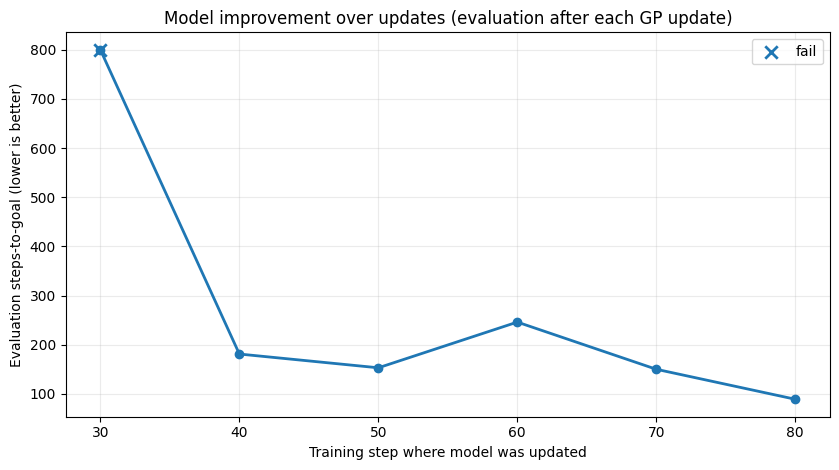


Eval Summary (after each update):
  upd=01 | train_step=0030 | FAIL | eval_steps=800 | dp_negELBO=-1.10e+02 dv_negELBO=-1.10e+02
  upd=02 | train_step=0040 | SUCCESS | eval_steps=181 | dp_negELBO=-1.49e+02 dv_negELBO=-1.49e+02
  upd=03 | train_step=0050 | SUCCESS | eval_steps=153 | dp_negELBO=-1.89e+02 dv_negELBO=-1.89e+02
  upd=04 | train_step=0060 | SUCCESS | eval_steps=246 | dp_negELBO=-2.28e+02 dv_negELBO=-2.28e+02
  upd=05 | train_step=0070 | SUCCESS | eval_steps=150 | dp_negELBO=-2.66e+02 dv_negELBO=-2.66e+02
  upd=06 | train_step=0080 | SUCCESS | eval_steps=089 | dp_negELBO=-3.05e+02 dv_negELBO=-3.05e+02

RENDER LAST UPDATE EVAL — update #6 at train_step 80
Rendered Eval: SUCCESS ✅ | steps=111/800 | wall=4.15s



FINAL 3D SURFACES (overlay n=84)


In [14]:
# ===========================
# Cell 12 — ONLINE-IN-EPISODE Streaming OSGPR-VFE + MPPI
#   ✅ One continuous episode (online updates every few steps)
#   ✅ Explore early -> Exploit later (within episode)
#   ✅ Optional: evaluation AFTER EVERY GP UPDATE (model at that time)
#   ✅ At end:
#        - plot evaluation steps-vs-update
#        - plot final 3D surfaces (Δp + Δv) once
#
# IMPORTANT:
#   - We ONLY train on EXECUTED real transitions (labels from env)
#   - MPPI candidates are used ONLY for inducing point selection Z (inputs-only)
# ===========================

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
from PIL import Image
import gpflow
from gpflow.utilities import deepcopy as gp_deepcopy


# ============================================================
# ===================== EASY TUNING KNOBS =====================
# ============================================================

# Episode
MAX_STEPS = 800
SEED = 0

# MPPI
HORIZON     = 60
NUM_SAMPLES = 128
NOISE_SIGMA = 0.35
LAM         = 1.0
U_SMOOTH    = 0.65

# Online update frequency
UPDATE_EVERY            = 10
ONLINE_BATCH            = 512
MIN_STEPS_BEFORE_UPDATE = 25

# Streaming update settings
M_INDUCING    = 48
TRAIN_ITERS   = 80
LR            = 0.005
MIN_NOISE_VAR = 1e-4

# Rendering (training episode)
RENDER = True
FRAME_STRIDE = 2
RESIZE = (720, 450)
FPS = 15

# Explore -> Exploit schedule WITHIN episode
EXPLORE_STEPS = 300
UNC_W_START   = 18.0
UNC_EVERY     = 5
UNC_SCALE     = 0.002

# Explore-mode exploit weights (weak)
EXPLORE_W_TIME = 0.10
EXPLORE_W_GOAL = 0.00
EXPLORE_W_TERM = 120.0

# Exploit-mode weights (Strategy A)
W_TIME     = 1.0
W_GOAL     = 0.0
W_TERMINAL = 350.0

# ============================================================
# ✅ NEW FEATURE: Evaluate after each model update
# ============================================================
EVAL_EACH_UPDATE          = True    # ✅ turn on/off this whole feature
EVAL_MAX_STEPS            = 800     # eval horizon in env steps (usually same as MAX_STEPS)
EVAL_RENDER_EACH_UPDATE   = False   # WARNING: slow if True (will show many videos)
EVAL_RENDER_LAST_ONLY     = True    # render only the LAST update's evaluation (recommended)

# Plot evaluation curve at end
PLOT_EVAL_CURVE_AT_END    = True

# ============================================================
# Optional: final 3D plots only ONCE at end
# ============================================================
PLOT_FINAL_3D_SURFACES = True     # uses plot_surface_mean_colored_by_std_interactive from Cell 10
PLOT_MAX_POINTS        = 3500     # overlay data amount for the surface plots

# 3D surface plot settings
SURF_N_GRID   = 80
SURF_P_MIN    = -1.2
SURF_P_MAX    = 0.6
SURF_V_MIN    = -0.07
SURF_V_MAX    = 0.07
SURF_A_FIXED  = +1.0

# optional z ranges
SURF_ZMIN_DP = None
SURF_ZMAX_DP = None
SURF_ZMIN_DV = -0.0035
SURF_ZMAX_DV = +0.0035


# ============================================================
# ===================== Small utils ===========================
# ============================================================

def resize_frame(frame, size=(720, 450)):
    if frame is None:
        return None
    img = Image.fromarray(frame)
    img = img.resize(size, Image.Resampling.LANCZOS)
    return np.array(img)

def show_frames(frames, fps=15):
    if len(frames) == 0:
        return
    fig = plt.figure(figsize=(RESIZE[0]/120, RESIZE[1]/120))
    ax = plt.gca()
    ax.axis("off")
    im = ax.imshow(frames[0])

    def animate(i):
        im.set_data(frames[i])
        return (im,)

    ani = animation.FuncAnimation(fig, animate, frames=len(frames),
                                  interval=1000/fps, blit=True)
    plt.close(fig)
    display(HTML(ani.to_jshtml()))

def unc_weight_by_step(t):
    if t >= EXPLORE_STEPS:
        return 0.0
    s = t / max(1, EXPLORE_STEPS)
    return float(UNC_W_START * (1.0 - s)**2)

def safe_set_min_noise(model, min_var=1e-4):
    try:
        cur = float(model.likelihood.variance.numpy())
        model.likelihood.variance.assign(np.maximum(min_var, cur))
    except Exception:
        pass


# ============================================================
# ============ k-center inducing point selection ==============
# ============================================================

def kcenter_greedy(Xcand, M, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)
    Xcand = np.asarray(Xcand, dtype=np.float64)
    N, D = Xcand.shape
    M = int(min(M, N))

    start = int(rng.integers(0, N))
    chosen = [start]
    d2 = np.sum((Xcand - Xcand[start])**2, axis=1)

    for _ in range(1, M):
        j = int(np.argmax(d2))
        chosen.append(j)
        d2 = np.minimum(d2, np.sum((Xcand - Xcand[j])**2, axis=1))

    return Xcand[np.array(chosen)]

def choose_Z_kcenter(Z_old, X_exec_batch, X_mppi_cand=None, M=48, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)

    Z_old = np.asarray(Z_old, dtype=np.float64)
    X_exec_batch = np.asarray(X_exec_batch, dtype=np.float64)

    if X_mppi_cand is not None and len(X_mppi_cand) > 0:
        X_mppi_cand = np.asarray(X_mppi_cand, dtype=np.float64)
        Xcand = np.vstack([Z_old, X_exec_batch, X_mppi_cand])
    else:
        Xcand = np.vstack([Z_old, X_exec_batch])

    return kcenter_greedy(Xcand, M=M, rng=rng)


# ============================================================
# =============== Online streaming update wrapper =============
# ============================================================

def streaming_update_online(m_dp, m_dv, kernel_dp, kernel_dv,
                            X_batch, ydp_batch, ydv_batch,
                            X_mppi_cand=None,
                            M=48, train_iters=80, lr=0.005,
                            rng=None):
    """
    Requires your existing functions:
      - extract_summary_from_model
      - OSGPR_VFE
      - train_osgpr
    """
    if rng is None:
        rng = np.random.default_rng(0)

    # --- dp ---
    mu_old, Su_old, Kaa_old, Z_old = extract_summary_from_model(m_dp)
    Z_new = choose_Z_kcenter(Z_old, X_batch, X_mppi_cand=X_mppi_cand, M=M, rng=rng)

    m_dp_new = OSGPR_VFE(
        data=(X_batch, ydp_batch),
        kernel=kernel_dp,
        mu_old=mu_old, Su_old=Su_old, Kaa_old=Kaa_old, Z_old=Z_old,
        Z=Z_new
    )
    m_dp_new.likelihood.variance.assign(np.maximum(MIN_NOISE_VAR, float(m_dp.likelihood.variance.numpy())))
    gpflow.set_trainable(m_dp_new.kernel, False)
    gpflow.set_trainable(m_dp_new.likelihood, True)
    t_dp, neg_dp = train_osgpr(m_dp_new, iters=train_iters, lr=lr)

    # --- dv ---
    mu_old, Su_old, Kaa_old, Z_old = extract_summary_from_model(m_dv)
    Z_new = choose_Z_kcenter(Z_old, X_batch, X_mppi_cand=X_mppi_cand, M=M, rng=rng)

    m_dv_new = OSGPR_VFE(
        data=(X_batch, ydv_batch),
        kernel=kernel_dv,
        mu_old=mu_old, Su_old=Su_old, Kaa_old=Kaa_old, Z_old=Z_old,
        Z=Z_new
    )
    m_dv_new.likelihood.variance.assign(np.maximum(MIN_NOISE_VAR, float(m_dv.likelihood.variance.numpy())))
    gpflow.set_trainable(m_dv_new.kernel, False)
    gpflow.set_trainable(m_dv_new.likelihood, True)
    t_dv, neg_dv = train_osgpr(m_dv_new, iters=train_iters, lr=lr)

    return m_dp_new, m_dv_new, (t_dp, neg_dp, t_dv, neg_dv)


# ============================================================
# ===================== Evaluation rollout ====================
# ============================================================

def run_eval_episode(env, rng, pred_dp, pred_dv,
                     eval_max_steps=800,
                     render=False,
                     w_time=1.0, w_goal=0.0, w_term=350.0):
    """
    Real evaluation:
      - w_unc = 0 (no exploration)
      - Strategy A exploit
    """
    obs, info = env.reset(seed=int(rng.integers(0, 2**31-1)))
    u_nom = np.zeros(HORIZON, dtype=np.float64)
    frames = []

    t0 = time.perf_counter()
    success = False

    for t in range(eval_max_steps):
        p, v = float(obs[0]), float(obs[1])

        u, u_nom, avg_cost, min_cost = mppi_plan_action_uncertainty(
            pred_dp, pred_dv,
            state0=np.array([p, v], dtype=np.float64),
            u_nominal=u_nom,
            rng=rng,
            horizon=HORIZON,
            num_samples=NUM_SAMPLES,
            noise_sigma=NOISE_SIGMA,
            lam=LAM,
            u_smooth=U_SMOOTH,
            w_time=w_time,
            w_goal=w_goal,
            w_terminal=w_term,
            w_unc=0.0,
            unc_scale=UNC_SCALE,
            unc_every=UNC_EVERY,
            return_u_candidates=False
        )

        obs2, reward, terminated, truncated, info = env.step(np.array([u], dtype=np.float64))
        obs = obs2

        if render and ((t % FRAME_STRIDE) == 0):
            frames.append(resize_frame(env.render(), RESIZE))

        if float(obs[0]) >= GOAL_POS:
            success = True
            break
        if terminated or truncated:
            break

    wall = time.perf_counter() - t0
    steps_used = t + 1
    return success, steps_used, wall, frames


# ============================================================
# ===================== RUN ONLINE TRAINING ===================
# ============================================================

needed = ["m_dp", "m_dv", "kernel_dp", "kernel_dv", "make_env"]
missing = [k for k in needed if k not in globals()]
if len(missing) > 0:
    raise NameError(f"Missing before Cell 12: {missing}")

if PLOT_FINAL_3D_SURFACES and ("plot_surface_mean_colored_by_std_interactive" not in globals()):
    print("[WARN] plot_surface_mean_colored_by_std_interactive not found. Run Cell 10 if you want final 3D plots.")
    PLOT_FINAL_3D_SURFACES = False

# cached predictors
pred_dp = build_cached_predictor_osgpr(m_dp)
pred_dv = build_cached_predictor_osgpr(m_dv)

safe_set_min_noise(m_dp, MIN_NOISE_VAR)
safe_set_min_noise(m_dv, MIN_NOISE_VAR)

rng = np.random.default_rng(SEED)

env = make_env(render_mode=("rgb_array" if RENDER else None), seed=SEED)
obs, info = env.reset(seed=SEED)

u_nom = np.zeros(HORIZON, dtype=np.float64)

X_exec   = []
Ydp_exec = []
Ydv_exec = []

frames = []
update_count = 0
hit_goal = False

# ==========================
# Eval records per update
# ==========================
eval_log = []  # list of dicts

t_start = time.perf_counter()

print("\n" + "="*95)
print("ONLINE TRAINING START")
print("="*95)

for t in range(MAX_STEPS):
    p, v = float(obs[0]), float(obs[1])

    # explore -> exploit schedule
    w_unc_t = unc_weight_by_step(t)
    do_explore = (w_unc_t > 1e-12)

    if do_explore:
        w_time_use = EXPLORE_W_TIME
        w_goal_use = EXPLORE_W_GOAL
        w_term_use = EXPLORE_W_TERM
        phase = "EXPLORE"
    else:
        w_time_use = W_TIME
        w_goal_use = W_GOAL
        w_term_use = W_TERMINAL
        phase = "EXPLOIT"

    # MPPI plan (+ candidates for inducing coverage)
    u, u_nom, avg_cost, min_cost, u_candidates = mppi_plan_action_uncertainty(
        pred_dp, pred_dv,
        state0=np.array([p, v], dtype=np.float64),
        u_nominal=u_nom,
        rng=rng,
        horizon=HORIZON,
        num_samples=NUM_SAMPLES,
        noise_sigma=NOISE_SIGMA,
        lam=LAM,
        u_smooth=U_SMOOTH,
        w_time=w_time_use,
        w_goal=w_goal_use,
        w_terminal=w_term_use,
        w_unc=w_unc_t,
        unc_scale=UNC_SCALE,
        unc_every=UNC_EVERY,
        return_u_candidates=True
    )

    # execute real step
    obs2, reward, terminated, truncated, info = env.step(np.array([u], dtype=np.float64))
    p2, v2 = float(obs2[0]), float(obs2[1])

    # store executed labeled transition
    X_exec.append([p, v, float(u)])
    Ydp_exec.append([p2 - p])
    Ydv_exec.append([v2 - v])

    obs = obs2

    if RENDER and ((t % FRAME_STRIDE) == 0):
        frames.append(resize_frame(env.render(), RESIZE))

    if (t % 25) == 0:
        print(f"[t={t:03d}] {phase:<7s} | p={p:+.3f} v={v:+.3f} u={u:+.2f} | w_unc={w_unc_t:.2f}")

    # stop if goal reached
    if p2 >= GOAL_POS:
        hit_goal = True
        print(f"\n✅ TRAIN HIT GOAL at step {t+1} (phase={phase}) p={p2:+.3f}")
        break

    if terminated or truncated:
        break

    # ============================
    # ONLINE STREAMING UPDATE
    # ============================
    if (t >= MIN_STEPS_BEFORE_UPDATE) and ((t + 1) % UPDATE_EVERY == 0):
        X_arr   = np.asarray(X_exec, dtype=np.float64)
        ydp_arr = np.asarray(Ydp_exec, dtype=np.float64).reshape(-1, 1)
        ydv_arr = np.asarray(Ydv_exec, dtype=np.float64).reshape(-1, 1)

        n = X_arr.shape[0]
        n_batch = int(min(ONLINE_BATCH, n))
        Xb   = X_arr[-n_batch:]
        ydpb = ydp_arr[-n_batch:]
        ydvb = ydv_arr[-n_batch:]

        # better Xcand: mix recent states with sampled candidate actions
        S_STATE = 32
        S_ACT   = 96

        S = min(S_STATE, n)
        SV = X_arr[-S:, :2]
        A  = u_candidates.astype(np.float64).reshape(-1)

        if A.shape[0] > S_ACT:
            idxA = rng.choice(A.shape[0], size=S_ACT, replace=False)
            A = A[idxA]

        idxS = rng.integers(0, SV.shape[0], size=A.shape[0])
        Xcand = np.column_stack([SV[idxS, 0], SV[idxS, 1], A])

        # update
        t_up0 = time.perf_counter()
        m_dp, m_dv, (t_dp, neg_dp, t_dv, neg_dv) = streaming_update_online(
            m_dp, m_dv, kernel_dp, kernel_dv,
            Xb, ydpb, ydvb,
            X_mppi_cand=Xcand,
            M=M_INDUCING, train_iters=TRAIN_ITERS, lr=LR,
            rng=rng
        )
        t_up = time.perf_counter() - t_up0
        update_count += 1

        safe_set_min_noise(m_dp, MIN_NOISE_VAR)
        safe_set_min_noise(m_dv, MIN_NOISE_VAR)

        # rebuild cached predictors
        pred_dp = build_cached_predictor_osgpr(m_dp)
        pred_dv = build_cached_predictor_osgpr(m_dv)

        print(f"  [UPDATE #{update_count:02d}] at step={t+1:04d} | last {n_batch} exec "
              f"| dp {t_dp:.2f}s negELBO={neg_dp:.2e} | dv {t_dv:.2f}s negELBO={neg_dv:.2e} | total {t_up:.2f}s")

        # =====================================================
        # ✅ NEW: EVALUATE THIS MODEL RIGHT NOW
        # =====================================================
        if EVAL_EACH_UPDATE:
            # render logic
            do_render = False
            if EVAL_RENDER_EACH_UPDATE:
                do_render = True
            elif EVAL_RENDER_LAST_ONLY:
                do_render = False  # set True later for last update (handled after loop)

            # snapshot current model for evaluation stability
            m_dp_snap = gp_deepcopy(m_dp)
            m_dv_snap = gp_deepcopy(m_dv)

            pred_dp_snap = build_cached_predictor_osgpr(m_dp_snap)
            pred_dv_snap = build_cached_predictor_osgpr(m_dv_snap)

            rng_eval = np.random.default_rng(SEED + 999 + update_count)
            env_eval = make_env(render_mode=("rgb_array" if do_render else None), seed=SEED + 999 + update_count)

            ok, steps_used, wall_used, frames_eval = run_eval_episode(
                env_eval, rng_eval, pred_dp_snap, pred_dv_snap,
                eval_max_steps=EVAL_MAX_STEPS,
                render=do_render,
                w_time=W_TIME, w_goal=W_GOAL, w_term=W_TERMINAL
            )
            env_eval.close()

            eval_log.append({
                "update": update_count,
                "train_step": int(t + 1),
                "success": bool(ok),
                "eval_steps": int(steps_used),
                "eval_wall": float(wall_used),
                "neg_elbo_dp": float(neg_dp),
                "neg_elbo_dv": float(neg_dv),
            })

            print(f"    [EVAL @ update #{update_count:02d}] {'SUCCESS ✅' if ok else 'FAIL ❌'} "
                  f"| steps={steps_used}/{EVAL_MAX_STEPS} | wall={wall_used:.2f}s")

env.close()

train_wall = time.perf_counter() - t_start

print("\n" + "="*95)
print(f"ONLINE TRAIN DONE | hit_goal={hit_goal} | steps={t+1} | updates={update_count} | wall={train_wall:.2f}s")
print("="*95)

if RENDER:
    show_frames(frames, fps=FPS)


# ============================================================
# ✅ Plot: Eval steps vs time/update
# ============================================================

if EVAL_EACH_UPDATE and PLOT_EVAL_CURVE_AT_END and (len(eval_log) > 0):
    steps_x = np.array([d["train_step"] for d in eval_log], dtype=int)
    steps_y = np.array([d["eval_steps"] for d in eval_log], dtype=int)
    succ    = np.array([d["success"] for d in eval_log], dtype=bool)

    plt.figure(figsize=(8.5, 4.8))
    plt.plot(steps_x, steps_y, marker="o", linewidth=2.0)
    plt.xlabel("Training step where model was updated")
    plt.ylabel("Evaluation steps-to-goal (lower is better)")
    plt.title("Model improvement over updates (evaluation after each GP update)")
    plt.grid(True, alpha=0.25)

    # mark failures
    if np.any(~succ):
        fx = steps_x[~succ]
        fy = steps_y[~succ]
        plt.scatter(fx, fy, marker="x", s=80, linewidths=2.0, label="fail")
        plt.legend()

    plt.tight_layout()
    plt.show()

    print("\nEval Summary (after each update):")
    for d in eval_log:
        print(f"  upd={d['update']:02d} | train_step={d['train_step']:04d} | "
              f"{'SUCCESS' if d['success'] else 'FAIL'} | eval_steps={d['eval_steps']:03d} | "
              f"dp_negELBO={d['neg_elbo_dp']:.2e} dv_negELBO={d['neg_elbo_dv']:.2e}")


# ============================================================
# ✅ Render LAST UPDATE evaluation (recommended)
# ============================================================

if EVAL_EACH_UPDATE and EVAL_RENDER_LAST_ONLY and (len(eval_log) > 0):
    last = eval_log[-1]
    print("\n" + "="*95)
    print(f"RENDER LAST UPDATE EVAL — update #{last['update']} at train_step {last['train_step']}")
    print("="*95)

    # Use current final model (after training)
    pred_dp_final = build_cached_predictor_osgpr(m_dp)
    pred_dv_final = build_cached_predictor_osgpr(m_dv)

    rng_eval = np.random.default_rng(SEED + 888)
    env_eval = make_env(render_mode="rgb_array", seed=SEED + 888)

    ok, steps_used, wall_used, frames_eval = run_eval_episode(
        env_eval, rng_eval, pred_dp_final, pred_dv_final,
        eval_max_steps=EVAL_MAX_STEPS,
        render=True,
        w_time=W_TIME, w_goal=W_GOAL, w_term=W_TERMINAL
    )
    env_eval.close()

    print(f"Rendered Eval: {'SUCCESS ✅' if ok else 'FAIL ❌'} | steps={steps_used}/{EVAL_MAX_STEPS} | wall={wall_used:.2f}s")
    show_frames(frames_eval, fps=FPS)


# ============================================================
# ✅ Final 3D surfaces (Δp + Δv) once
# ============================================================

if PLOT_FINAL_3D_SURFACES:
    if "plot_surface_mean_colored_by_std_interactive" in globals():
        Nplot = min(len(X_exec), PLOT_MAX_POINTS)
        idxP = np.linspace(max(0, len(X_exec)-Nplot), len(X_exec)-1, Nplot).astype(int)

        X_plot   = np.asarray(X_exec, dtype=np.float64)[idxP]
        ydp_plot = np.asarray(Ydp_exec, dtype=np.float64).reshape(-1)[idxP]
        ydv_plot = np.asarray(Ydv_exec, dtype=np.float64).reshape(-1)[idxP]

        print("\n" + "="*95)
        print(f"FINAL 3D SURFACES (overlay n={X_plot.shape[0]})")
        print("="*95)

        plot_surface_mean_colored_by_std_interactive(
            m_dp, X_plot, ydp_plot,
            title="FINAL OSGPR-VFE surface: Δp",
            z_label="Δp",
            a_fixed=SURF_A_FIXED,
            n_grid=SURF_N_GRID,
            p_min=SURF_P_MIN, p_max=SURF_P_MAX,
            v_min=SURF_V_MIN, v_max=SURF_V_MAX,
            z_min=SURF_ZMIN_DP, z_max=SURF_ZMAX_DP,
            std_min=0.0, std_max=None,
            show_inducing=True,
            inducing_tol_a=0.2
        )

        plot_surface_mean_colored_by_std_interactive(
            m_dv, X_plot, ydv_plot,
            title="FINAL OSGPR-VFE surface: Δv",
            z_label="Δv",
            a_fixed=SURF_A_FIXED,
            n_grid=SURF_N_GRID,
            p_min=SURF_P_MIN, p_max=SURF_P_MAX,
            v_min=SURF_V_MIN, v_max=SURF_V_MAX,
            z_min=SURF_ZMIN_DV, z_max=SURF_ZMAX_DV,
            std_min=0.0, std_max=None,
            show_inducing=True,
            inducing_tol_a=0.2
        )
    else:
        print("[WARN] plot_surface_mean_colored_by_std_interactive not found. Run Cell 10 first.")
